# Stacked Machine Learning

In [2]:
## IMPORTANT !

# In the first order need to set the number of CPU 
# for calculation before launching (depends on computer's number of cores)
n_jobs= 30

### Load libraries

In [3]:
#libraries
import pandas as pd
import numpy as np
import os
import sys
import shutil
import glob
import joblib
import warnings
from datetime import date, datetime

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeavePGroupsOut
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr
import scipy.stats as st

from nilearn import image as nli
from nilearn import plotting

#from mne.viz import plot_connectivity_circle
from mne_connectivity.viz import plot_connectivity_circle

import matplotlib.patches as mpatches

### Path to the tables folder

##### path

In [4]:
#path to folders with prepared tables
path_tab_sp = '/media/hcs-psy-narun/Nesi/HCP_YA_Cognitive_Predicition/ML_ready_tables_residuals_folds/'
print(sorted(os.listdir(path_tab_sp)))

['Fold_0', 'Fold_1', 'Fold_2', 'Fold_3', 'Fold_4', 'Fold_5', 'Fold_6', 'Fold_7']


In [5]:
#path to folder with results
path_tab_res = '/media/hcs-psy-narun/Alina_results/Alina3/ML_ready_tables_residuals_folds/'

In [6]:
path_tab_res_flat = '/media/hcs-psy-narun/Alina_results/Alina3/flat/noRace_tables/'

In [7]:
#create output directory
os.mkdir('/media/hcs-psy-narun/Alina_results/Alina3/mainset_outputs/')

In [8]:
path_out = '/media/hcs-psy-narun/Alina_results/Alina3/mainset_outputs/'

#### load results table

In [9]:
#load results
dct_results={}
for i in sorted(glob.glob(path_tab_res+'tables_*')):
    dct_results[i.split('/')[-1].split('.')[0].split('_')[1]] = pd.read_csv(i, index_col=0)

In [10]:
#load results for flat
#dct_results_flat={}
for i in sorted(glob.glob(path_tab_res_flat+'tables_*')):
    dct_results['flat+'+('_'.join(i.split('/')[-1].split('.')[0].split('_')[1:3]))] = pd.read_csv(i, index_col=0)

In [11]:
[i for i in dct_results.keys()]

['eNet+eNet',
 'eNet+rf',
 'eNet+svr',
 'eNet+xgb',
 'eNet',
 'rf+eNet',
 'rf+rf',
 'rf+svr',
 'rf+xgb',
 'rf',
 'svr+eNet',
 'svr+rf',
 'svr+svr',
 'svr+xgb',
 'svr',
 'xgb+eNet',
 'xgb+rf',
 'xgb+svr',
 'xgb+xgb',
 'xgb',
 'flat+eNet_all',
 'flat+eNet_non-task',
 'flat+eNet_task',
 'flat+eNet_top-task',
 'flat+rf_all',
 'flat+rf_non-task',
 'flat+rf_task',
 'flat+rf_top-task',
 'flat+svr_all',
 'flat+svr_non-task',
 'flat+svr_task',
 'flat+svr_top-task',
 'flat+xgb_all',
 'flat+xgb_non-task',
 'flat+xgb_task',
 'flat+xgb_top-task']

In [12]:
#indexes for subject
dct_indx = {}
for i in sorted(glob.glob(path_tab_sp+'Fold_*/target_y_test.csv')):
    dct_indx[i.split('/')[-2]] = pd.read_csv(i, index_col=0, header=None)
    
i, x, z = dct_indx['Fold_0'].index.values, dct_indx['Fold_0'][1].values, np.full(len(dct_indx['Fold_0'].index), 0)
#dct_indx_concat={}
for key in sorted(dct_indx.keys())[1:]:
    i = np.concatenate((i, dct_indx[key].index.values) , axis=None)
    x = np.concatenate((x, dct_indx[key][1].values) , axis=None)
    z = np.concatenate((z, np.full(len(dct_indx[key].index), key.split('_')[-1])) , axis=None)

df_indx = pd.DataFrame({'sID': i,
                     'y_real': x,
                     'fold':z})
df_indx.index=df_indx['sID']
#display(df_indx)

In [13]:
#organize in a bit different way
for key in dct_results.keys():
    #print(key)
    dct_results[key].index = df_indx['sID'].values
    if 'flat' not in key:
        dct_results[key] = dct_results[key].drop(['y_true', 'fold'], axis=1)
        dct_results[key] = pd.concat([dct_results[key], df_indx[['y_real', 'fold']]], axis=1)
    if 'flat' in key:
        dct_results[key] = dct_results[key].drop(['y_true'], axis=1)
        dct_results[key] = pd.concat([dct_results[key], df_indx[['y_real', 'fold']]], axis=1)
        dct_results[key].columns = ['all', 'y_real', 'fold']
    #display(dct_results[key])

In [14]:
#combine Ftat model results into one table

key_with_flat = [i for i in dct_results.keys() if 'flat' in i]


for newkey in ['flat+eNet', 'flat+rf', 'flat+svr', 'flat+xgb']:
    dct_results[newkey] = pd.DataFrame({'all':dct_results[newkey+'_all']['all'],
                                    'task':dct_results[newkey+'_task']['all'], 
                                    'non-task':dct_results[newkey+'_non-task']['all'],
                                    'top-task':dct_results[newkey+'_top-task']['all'],
                                    'y_real':dct_results[newkey+'_top-task']['y_real'],
                                    'fold':dct_results[newkey+'_top-task']['fold']}, 
                                   index=dct_results[newkey+'_top-task'].index)
    
for k in key_with_flat:
    del dct_results[k]

In [15]:
[i for i in dct_results.keys()]

['eNet+eNet',
 'eNet+rf',
 'eNet+svr',
 'eNet+xgb',
 'eNet',
 'rf+eNet',
 'rf+rf',
 'rf+svr',
 'rf+xgb',
 'rf',
 'svr+eNet',
 'svr+rf',
 'svr+svr',
 'svr+xgb',
 'svr',
 'xgb+eNet',
 'xgb+rf',
 'xgb+svr',
 'xgb+xgb',
 'xgb',
 'flat+eNet',
 'flat+rf',
 'flat+svr',
 'flat+xgb']

# Bootstraping

In [16]:
#initial indexing
bindex = dct_results['eNet'].index

#dicts for results
dct_bootstrap_r2 = {}
dct_bootstrap_mse = {}
dct_bootstrap_mae = {}
dct_bootstrap_cor = {}
dct_bootstrap_MEAN = {}

#add second layer to output dicts
for KEY in dct_results.keys():
    dct_bootstrap_r2[KEY] = {}
    dct_bootstrap_mse[KEY] = {}
    dct_bootstrap_mae[KEY] = {}
    dct_bootstrap_cor[KEY] = {}

#bootstrapping
i=0
while i<5000: #number of trials
    #shuffled index 
    bbindex = resample(bindex, replace=True, n_samples=len(bindex), random_state=i) 
    
    #apply shuffled index to all tables
    for KEY in dct_results.keys():
        
        data = dct_results[KEY].reindex(index=bbindex)
        
        #calculate indexes
        cor, r2, mse, mae, cols = [], [], [], [], []
        for col in data.columns[0:-2]:
            corr, _ = pearsonr(data['y_real'], data[col])
            cor += [corr]
            r2 += [r2_score(data['y_real'], data[col])]
            mse += [mean_squared_error(data['y_real'], data[col])]
            mae += [mean_absolute_error(data['y_real'], data[col])]
            cols +=[col]
        # series of indexes for #i iteration
        dct_bootstrap_r2[KEY][i] = pd.Series(r2, index=cols)
        dct_bootstrap_mse[KEY][i] = pd.Series(mse, index=cols)
        dct_bootstrap_mae[KEY][i] = pd.Series(mae, index=cols)
        dct_bootstrap_cor[KEY][i] = pd.Series(cor, index=cols)
  
    i+=1
    
#reformating second layer of dicts into tables    
for KEY in dct_results.keys():
    dct_bootstrap_r2[KEY] = pd.DataFrame(dct_bootstrap_r2[KEY]).T
    dct_bootstrap_mse[KEY] = pd.DataFrame(dct_bootstrap_mse[KEY]).T
    dct_bootstrap_mae[KEY] = pd.DataFrame(dct_bootstrap_mae[KEY]).T
    dct_bootstrap_cor[KEY] = pd.DataFrame(dct_bootstrap_cor[KEY]).T
    dct_bootstrap_MEAN[KEY] = pd.DataFrame({'r2': pd.DataFrame(dct_bootstrap_r2[KEY]).mean(),
                                            'mse': pd.DataFrame(dct_bootstrap_mse[KEY]).mean(),
                                            'mae': pd.DataFrame(dct_bootstrap_mae[KEY]).mean(),
                                            'cor': pd.DataFrame(dct_bootstrap_cor[KEY]).mean()})
    print(KEY)
    print('Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds')
    display(dct_bootstrap_MEAN[KEY].sort_values(by='r2', ascending=False))


eNet+eNet
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
all,0.323621,132.488895,9.334945,0.570131
task,0.304031,136.339934,9.416873,0.552802
top-task,0.294926,138.125863,9.458337,0.544324
non-task,0.067819,182.660057,10.977530,0.264776


eNet+rf
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
all,0.293024,138.502178,9.593912,0.549106
task,0.282236,140.626523,9.582178,0.537483
top-task,0.271606,142.704643,9.659958,0.523981
non-task,0.062517,183.701246,10.997227,0.256759


eNet+svr
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
task,0.296084,137.889795,9.477121,0.546857
top-task,0.292820,138.533362,9.392678,0.545627
all,0.292046,138.662155,9.497812,0.546321
non-task,0.044234,187.270159,11.076057,0.248098


eNet+xgb
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
all,0.279081,141.209489,9.579282,0.530584
task,0.275939,141.839237,9.564601,0.527218
top-task,0.274144,142.188877,9.513665,0.526022
non-task,0.023054,191.400370,11.272266,0.234283


eNet
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
wm,0.230690,150.739988,9.866380,0.484807
lan,0.143569,167.824194,10.451728,0.381598
rel,0.085667,179.195127,10.734116,0.295171
surf,0.063250,183.571657,10.997892,0.254844
mot,0.039983,188.152090,11.146825,0.203210
soc,0.039713,188.216955,11.043704,0.208872
VolBrain,0.036090,188.911541,11.124369,0.193288
emo,0.024849,191.117954,11.200426,0.169492
rest-pca75,0.020861,191.904471,11.182715,0.149306
subc,0.018780,192.308877,11.242249,0.144095


rf+eNet
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
all,0.284794,140.095401,9.620696,0.534760
task,0.260800,144.812229,9.716150,0.511882
top-task,0.256463,145.665759,9.753506,0.507560
non-task,0.056302,184.924055,11.033772,0.242978


rf+rf
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
task,0.246879,147.548316,9.844089,0.498484
all,0.246866,147.538669,9.931169,0.498219
top-task,0.234333,150.010786,9.865803,0.485454
non-task,0.048646,186.431875,11.053941,0.226977


rf+svr
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
all,0.252060,146.491477,9.782380,0.514117
top-task,0.241057,148.682760,9.825285,0.497219
task,0.238315,149.208674,9.804314,0.496300
non-task,0.044061,187.321124,11.067929,0.244496


rf+xgb
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
task,0.244028,148.087074,9.808831,0.497801
all,0.233829,150.076125,10.010383,0.488781
top-task,0.231908,150.463428,9.814789,0.487675
non-task,0.015475,192.906802,11.216851,0.203223


rf
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
wm,0.187882,159.136140,10.170217,0.439220
lan,0.110140,174.400810,10.626860,0.347790
rel,0.071971,181.877146,10.875723,0.271456
surf,0.057750,184.652184,11.028708,0.244412
soc,0.048610,186.455696,11.009500,0.223235
emo,0.031965,189.725199,11.181422,0.182169
VolBrain,0.030674,189.975104,11.150917,0.178487
mot,0.025978,190.900934,11.173556,0.165810
subc,0.019042,192.259048,11.232342,0.147948
rest-pca75,0.008530,194.323387,11.278223,0.104316


svr+eNet
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
all,0.305113,136.109344,9.417255,0.553326
task,0.285289,140.006902,9.526964,0.535229
top-task,0.273357,142.350364,9.543480,0.524090
non-task,0.067928,182.638672,10.969381,0.267584


svr+rf
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
all,0.270921,142.829958,9.658118,0.522498
task,0.258942,145.185152,9.697295,0.510389
top-task,0.241468,148.612570,9.825684,0.493270
non-task,0.061220,183.970851,10.948827,0.250207


svr+svr
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
all,0.292447,138.584007,9.541673,0.544973
task,0.271876,142.615959,9.619951,0.528096
top-task,0.260938,144.775087,9.604331,0.518398
non-task,0.043916,187.345205,11.051275,0.249271


svr+xgb
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
all,0.269549,143.083505,9.636952,0.520945
top-task,0.255866,145.767857,9.666744,0.509735
task,0.249213,147.069279,9.699328,0.503597
non-task,0.035427,188.995620,11.104178,0.232783


svr
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
wm,0.224438,151.949693,9.811486,0.480931
lan,0.101855,175.992239,10.593804,0.333005
rel,0.078652,180.544649,10.755071,0.294093
surf,0.052195,185.745845,10.993577,0.238737
mot,0.048695,186.424316,11.036505,0.229721
emo,0.029634,190.162841,11.152489,0.193768
soc,0.027890,190.513617,11.142750,0.191181
VolBrain,0.021843,191.708023,11.130835,0.170363
rest-pca75,0.007378,194.547951,11.240339,0.135555
cort,0.002334,195.532926,11.265586,0.113965


xgb+eNet
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
all,0.249758,146.961069,9.907444,0.501643
task,0.237661,149.345013,9.898943,0.489250
top-task,0.233025,150.264753,9.924542,0.484309
non-task,0.041656,187.801564,11.115890,0.210959


xgb+rf
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
all,0.234632,149.953025,9.946649,0.490691
task,0.222297,152.380601,9.943746,0.476213
top-task,0.207973,155.198607,10.046173,0.460872
non-task,0.038684,188.389790,11.103064,0.201560


xgb+svr
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
all,0.240618,148.745068,9.898077,0.502370
task,0.227655,151.296664,9.881115,0.487985
top-task,0.205157,155.721241,10.073413,0.462404
non-task,0.049355,186.284765,11.022812,0.252812


xgb+xgb
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
all,0.212643,154.238028,10.122300,0.464750
top-task,0.202015,156.338240,10.137850,0.453736
task,0.199600,156.804254,10.068639,0.451437
non-task,0.012718,193.457389,11.182270,0.187894


xgb
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
wm,0.189588,158.782186,10.080561,0.437171
lan,0.095617,177.230254,10.671788,0.312600
rel,0.042726,187.595783,11.071311,0.230877
soc,0.040365,188.074479,11.082510,0.204389
surf,0.030996,189.883893,11.195326,0.190211
subc,0.024007,191.284336,11.222603,0.162454
VolBrain,0.020814,191.900321,11.225858,0.160554
mot,0.015881,192.867508,11.218329,0.151957
emo,0.008404,194.332915,11.335134,0.130985
rest-pca75,0.006016,194.807612,11.242249,0.118406


flat+eNet
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
all,0.309351,135.298930,9.478144,0.560486
top-task,0.303696,136.418211,9.432534,0.554535
task,0.286092,139.874976,9.583241,0.543187
non-task,0.056889,184.801076,11.015041,0.249378


flat+rf
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
top-task,0.222300,152.391905,10.025647,0.485744
all,0.215899,153.647516,10.064846,0.488836
task,0.206768,155.440238,10.111827,0.474069
non-task,0.060300,184.150907,11.011148,0.248330


flat+svr
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
all,0.317295,133.716036,9.325737,0.565562
task,0.306599,135.828472,9.332935,0.556299
top-task,0.302615,136.615240,9.322659,0.553635
non-task,0.038135,188.466896,11.081849,0.236456


flat+xgb
Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


,r2,mse,mae,cor
all,0.251529,146.631407,9.822730,0.503416
task,0.249921,146.964570,9.838518,0.504659
top-task,0.244234,148.062031,9.854372,0.495349
non-task,0.038152,188.474928,11.164344,0.217438


In [17]:
#confidence intervals for bootstrap, R2 ONLY!
print('R2 Confidence Intervals')
CI_dct_bootstrap_r2= {}
for KEY in dct_bootstrap_r2.keys():
    dataset = dct_bootstrap_r2[KEY]

    CI1, CI2, colss = [],[], []
    for col in dataset.columns:
        CI1 += [(st.t.interval(alpha=0.95, df=len(dataset[col])-1, loc=np.mean(dataset[col]), scale=np.std(dataset[col])))[0]]
        CI2 += [(st.t.interval(alpha=0.95, df=len(dataset[col])-1, loc=np.mean(dataset[col]), scale=np.std(dataset[col])))[1]]
        colss += [col]
    df_CI = pd.DataFrame({'CI1':CI1, 'CI2':CI2}, index=colss)#.sort_values(by='CI1', ascending=True)
    CI_dct_bootstrap_r2[KEY]=df_CI
    print(KEY)
    display(df_CI)

R2 Confidence Intervals
eNet+eNet


,CI1,CI2
all,0.274027,0.373215
task,0.254202,0.353861
non-task,0.030914,0.104724
top-task,0.245270,0.344582


eNet+rf


,CI1,CI2
all,0.249521,0.336528
task,0.237094,0.327378
non-task,0.025756,0.099278
top-task,0.225256,0.317957


eNet+svr


,CI1,CI2
all,0.235140,0.348951
task,0.242501,0.349668
non-task,-0.000140,0.088608
top-task,0.239715,0.345924


eNet+xgb


,CI1,CI2
all,0.224706,0.333455
task,0.221036,0.330842
non-task,-0.026942,0.073051
top-task,0.217859,0.330429


eNet


,CI1,CI2
wm,0.186639,0.274740
lan,0.102795,0.184343
rel,0.051973,0.119360
mot,0.015667,0.064299
emo,-0.004660,0.054359
soc,0.018890,0.060536
gam,-0.005551,0.001822
rest-pca75,-0.000591,0.042314
surf,0.033971,0.092528
VolBrain,0.013799,0.058382


rf+eNet


,CI1,CI2
all,0.233515,0.336074
task,0.209503,0.312096
non-task,0.020356,0.092248
top-task,0.205979,0.306948


rf+rf


,CI1,CI2
all,0.199228,0.294504
task,0.198574,0.295183
non-task,0.015359,0.081933
top-task,0.186803,0.281863


rf+svr


,CI1,CI2
all,0.191880,0.312241
task,0.179469,0.297161
non-task,0.003842,0.084279
top-task,0.187810,0.294304


rf+xgb


,CI1,CI2
all,0.178496,0.289162
task,0.188862,0.299194
non-task,-0.030928,0.061877
top-task,0.174490,0.289326


rf


,CI1,CI2
wm,0.146163,0.229600
lan,0.079644,0.140637
rel,0.041067,0.102874
mot,0.004947,0.047010
emo,0.008722,0.055209
soc,0.018709,0.078511
gam,-0.006964,0.022128
rest-pca75,-0.010583,0.027644
surf,0.030936,0.084563
VolBrain,0.006679,0.054669


svr+eNet


,CI1,CI2
all,0.252735,0.357491
task,0.233698,0.336879
non-task,0.027322,0.108533
top-task,0.220824,0.325889


svr+rf


,CI1,CI2
all,0.222973,0.318869
task,0.210722,0.307161
non-task,0.028153,0.094287
top-task,0.195073,0.287864


svr+svr


,CI1,CI2
all,0.236628,0.348266
task,0.213995,0.329757
non-task,0.000919,0.086913
top-task,0.204293,0.317583


svr+xgb


,CI1,CI2
all,0.215299,0.323799
task,0.191276,0.307151
non-task,-0.011648,0.082502
top-task,0.199057,0.312675


svr


,CI1,CI2
wm,0.172278,0.276597
lan,0.051400,0.152310
rel,0.034435,0.122870
mot,0.013978,0.083412
emo,-0.004087,0.063355
soc,-0.008545,0.064326
gam,-0.027459,0.022871
rest-pca75,-0.020190,0.034947
surf,0.021725,0.082665
VolBrain,-0.004385,0.048071


xgb+eNet


,CI1,CI2
all,0.197981,0.301535
task,0.185958,0.289364
non-task,0.008607,0.074705
top-task,0.184061,0.281989


xgb+rf


,CI1,CI2
all,0.192113,0.277151
task,0.178706,0.265888
non-task,0.008988,0.068380
top-task,0.167201,0.248744


xgb+svr


,CI1,CI2
all,0.184056,0.297180
task,0.168938,0.286373
non-task,0.009960,0.088751
top-task,0.151749,0.258564


xgb+xgb


,CI1,CI2
all,0.159840,0.265445
task,0.145153,0.254046
non-task,-0.032286,0.057722
top-task,0.151630,0.252400


xgb


,CI1,CI2
wm,0.139467,0.239710
lan,0.053301,0.137934
rel,0.001736,0.083715
mot,-0.015477,0.047240
emo,-0.019893,0.036701
soc,0.009933,0.070798
gam,-0.026049,0.017566
rest-pca75,-0.020722,0.032754
surf,-0.004414,0.066406
VolBrain,-0.008299,0.049927


flat+eNet


,CI1,CI2
all,0.262515,0.356188
task,0.242381,0.329802
non-task,0.017856,0.095922
top-task,0.257710,0.349682


flat+rf


,CI1,CI2
all,0.180512,0.251285
task,0.170532,0.243004
non-task,0.030642,0.089958
top-task,0.183803,0.260796


flat+svr


,CI1,CI2
all,0.261666,0.372925
task,0.252982,0.360216
non-task,-0.007281,0.083551
top-task,0.249750,0.355480


flat+xgb


,CI1,CI2
all,0.203086,0.299971
task,0.205829,0.294013
non-task,-0.000066,0.076369
top-task,0.195028,0.293440


In [17]:
#save bootstraped tables
os.mkdir(path_out+'bootstrap_table')
for key in dct_bootstrap_r2.keys():
    dct_bootstrap_r2[key].to_csv(path_out+'bootstrap_table/'+'BTSTRP_r2_'+str(key)+'.csv')
    dct_bootstrap_mse[key].to_csv(path_out+'bootstrap_table/'+'BTSTRP_mse_'+str(key)+'.csv')
    dct_bootstrap_mae[key].to_csv(path_out+'bootstrap_table/'+'BTSTRP_mae_'+str(key)+'.csv')
    dct_bootstrap_cor[key].to_csv(path_out+'bootstrap_table/'+'BTSTRP_cor_'+str(key)+'.csv')
    dct_bootstrap_MEAN[key].to_csv(path_out+'bootstrap_table/'+'BTSTRP_MEAN_'+str(key)+'.csv')

## Bootstrap plot

##### reorganize tables for plotting

###### r2

In [18]:
#stack into one table for plot
#r2

dct_plot_tab_r2 = {}

for model in dct_bootstrap_r2['eNet+eNet'].columns:

    #combine into one table by type of model
    v1 = []
    v2 = []
    dfdf = pd.DataFrame()
    for key in dct_bootstrap_r2.keys():
        if len(key.split('+')) >=2:
            v1 += [key.split('+')[0]]
            v2 += [key.split('+')[1]]
            dfdf[key] = dct_bootstrap_r2[key][model]                 
    
    #change names to upper case        
    V1=[]
    for i in v1:
        if i in ['svr', 'rf', 'xgb']:
            V1 += [i.upper()]
        else: 
            V1 += [i]    
    V2=[]
    for i in v2:
        if i in ['svr', 'rf', 'xgb']:
            V2 += [i.upper()]
        else: 
            V2 += [i]    

    #multi-index        
    collumnss = pd.MultiIndex.from_tuples(list(zip( V1,V2)), names=["single", "stack"])
    dfdf.columns=collumnss


    #reorganize table into long one for easy plotting

    dct_t2 = {}
    for col in dfdf.columns:
        nums = dfdf[col].values
        inds1 = np.full(len(dfdf[col].values), col[0])
        inds2 = np.full(len(dfdf[col].values), col[1])
        dct_t2[('_'.join(col))] = pd.DataFrame({'$R^2$': nums, 'Single Modality \nAlgorithm':inds1, 
                                                'Stacking Algorithm':inds2})

    #table for plot
    dfdf2 = dct_t2[sorted(dct_t2.keys())[0]]
    for key in sorted(dct_t2.keys())[1:]:
        dfdf2 = pd.concat([dfdf2, dct_t2[key]], axis=0, ignore_index=True)
    #display(dfdf2)

    dct_plot_tab_r2[model]=dfdf2

##### Bootstrap plot

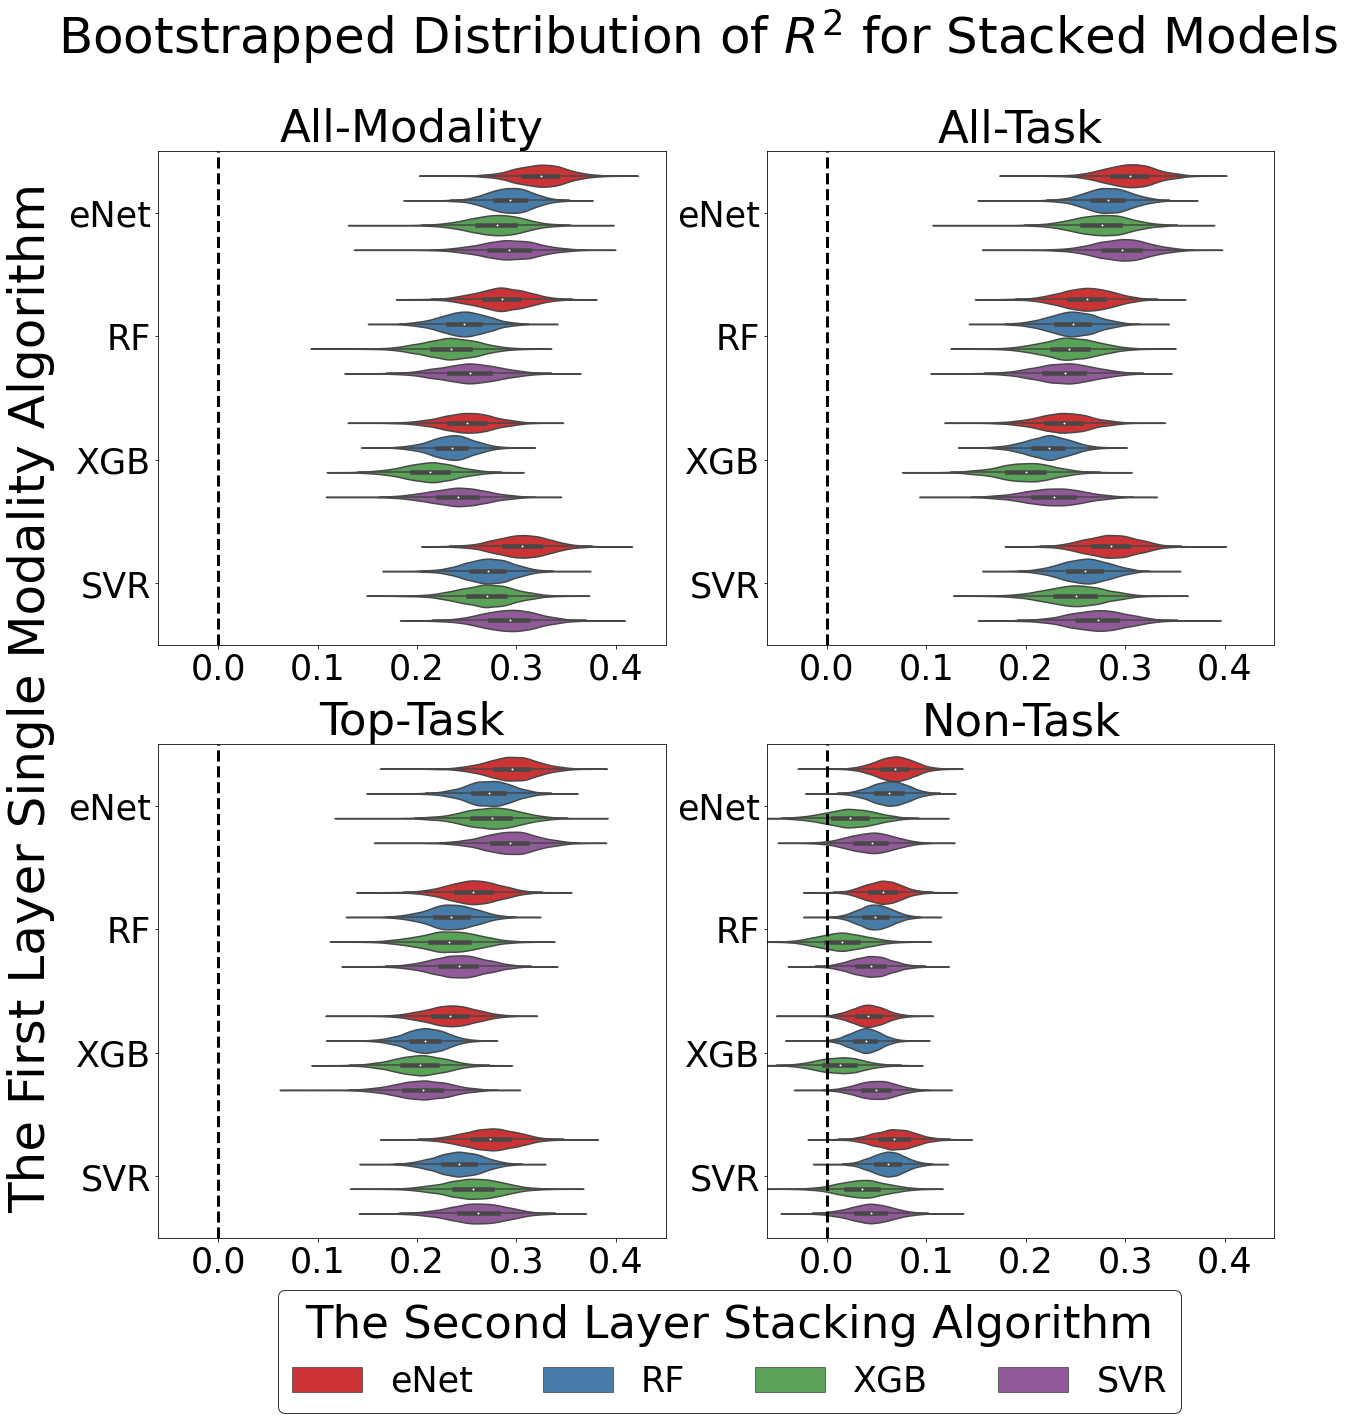

In [19]:
fig = plt.figure(figsize=(20,20))
palette = "Set1"
font1=28
font2=35
font3=45

plt.suptitle('Bootstrapped Distribution of $R^2$ for Stacked Models', fontsize=50)




plt.subplot(2,2,1)
plt.title('All-Modality', fontsize=font3)
sns.violinplot(x='$R^2$', y='Single Modality \nAlgorithm', hue='Stacking Algorithm', 
               data = dct_plot_tab_r2['all'][dct_plot_tab_r2['all']['Single Modality \nAlgorithm']!='flat'], 
               palette=palette,
               order=['eNet', 'RF', 'XGB','SVR'],
               hue_order=['eNet', 'RF', 'XGB','SVR'])
plt.legend([],[], frameon=False)
plt.xticks(fontsize=font2)
plt.yticks(fontsize=font2)
plt.xlabel('',fontsize=font3)
plt.ylabel('',fontsize=font3)
plt.xlim((-0.06, 0.45))
plt.axvline(0, color='black', linestyle='dashed', linewidth=3)




plt.subplot(2,2,2)
plt.title('All-Task', fontsize=font3)
sns.violinplot(x='$R^2$', y='Single Modality \nAlgorithm', hue='Stacking Algorithm', 
               data = dct_plot_tab_r2['task'][dct_plot_tab_r2['task']['Single Modality \nAlgorithm']!='flat'], 
               palette=palette,
               order=['eNet', 'RF', 'XGB','SVR'],
               hue_order=['eNet', 'RF', 'XGB','SVR'])
plt.legend([],[], frameon=False)
plt.xticks(fontsize=font2)
plt.yticks(fontsize=font2)
plt.xlabel('',fontsize=font3)
plt.ylabel('',fontsize=font3)
plt.xlim((-0.06, 0.45))
plt.axvline(0, color='black', linestyle='dashed', linewidth=3)



plt.subplot(2,2,4)
plt.title('Non-Task', fontsize=font3)
sns.violinplot(x='$R^2$', y='Single Modality \nAlgorithm', hue='Stacking Algorithm', 
               data = dct_plot_tab_r2['non-task'][dct_plot_tab_r2['non-task']['Single Modality \nAlgorithm']!='flat'], 
               palette=palette,
               order=['eNet', 'RF', 'XGB','SVR'],
               hue_order=['eNet', 'RF', 'XGB','SVR'])
plt.legend(loc='upper right', fontsize=font2, bbox_to_anchor=(0.85, -0.07), 
           title="The Second Layer Stacking Algorithm", title_fontsize=font3, ncol=4, edgecolor='black')

plt.xticks(fontsize=font2)
plt.yticks(fontsize=font2)
plt.xlabel('',fontsize=10)
plt.ylabel('',fontsize=font3)
plt.xlim((-0.06, 0.45))
plt.axvline(0, color='black', linestyle='dashed', linewidth=3)



plt.subplot(2,2,3)
plt.title('Top-Task', fontsize=font3)
sns.violinplot(x='$R^2$', y='Single Modality \nAlgorithm', hue='Stacking Algorithm', 
               data = dct_plot_tab_r2['top-task'][dct_plot_tab_r2['top-task']['Single Modality \nAlgorithm']!='flat'], 
               palette=palette,
               order=['eNet', 'RF', 'XGB','SVR'],
               hue_order=['eNet', 'RF', 'XGB','SVR'])
plt.legend([],[], frameon=False)
plt.xticks(fontsize=font2)
plt.yticks(fontsize=font2)
plt.xlabel('',fontsize=10)
plt.ylabel('',fontsize=font3)
plt.xlim((-0.06, 0.45))
plt.axvline(0, color='black', linestyle='dashed', linewidth=3)

#fig.tight_layout(pad=1)

#fig.supxlabel('$R^2$', fontsize=50)
fig.supylabel('The First Layer Single Modality Algorithm', fontsize=50)

plt.show()

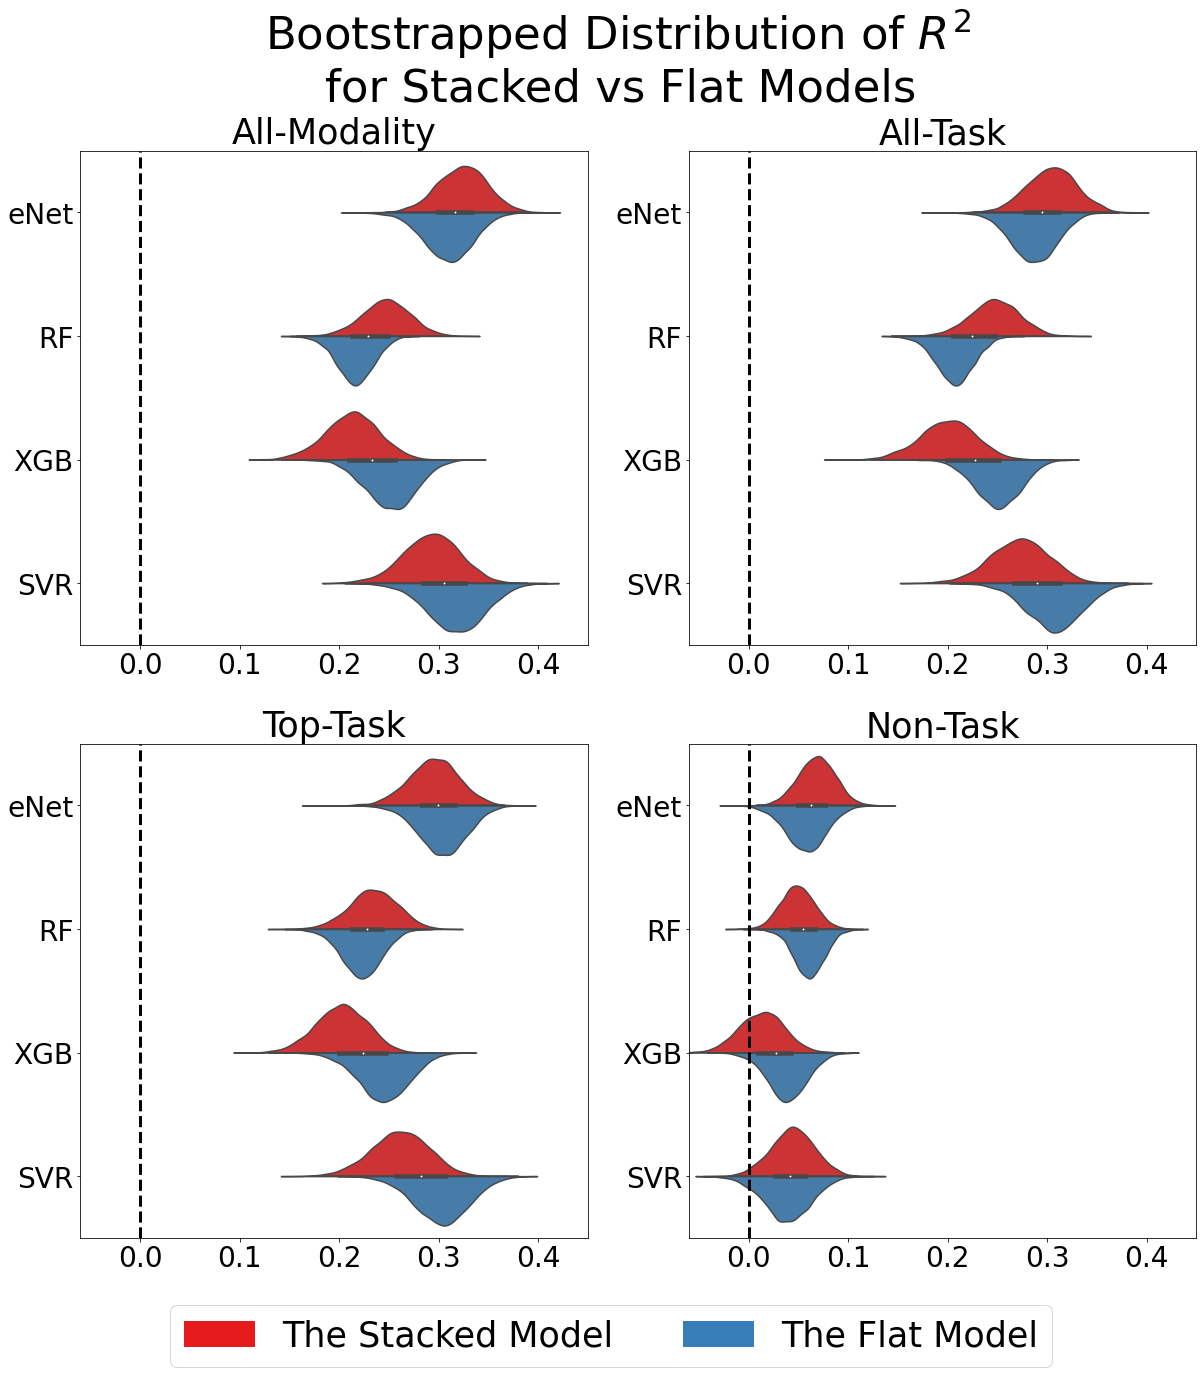

In [20]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

fig = plt.figure(figsize=(20,20))
palette = "Set1"
font1=28
font2=35
font3=45


plt.suptitle('Bootstrapped Distribution of $R^2$ \nfor Stacked vs Flat Models', fontsize=font3)


plt.subplot(2,2,1)
#####
st_type='all'
plt.title('All-Modality', fontsize=font2)
data1 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='flat']
data2 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='RF'][dct_plot_tab_r2[st_type]['Stacking Algorithm']=='RF']
data3 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='SVR'][dct_plot_tab_r2[st_type]['Stacking Algorithm']=='SVR']
data4 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='XGB'][dct_plot_tab_r2[st_type]['Stacking Algorithm']=='XGB']
data5 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='eNet'][dct_plot_tab_r2[st_type]['Stacking Algorithm']=='eNet']

Data = pd.concat([data2, data3, data4, data5, data1], axis=0, ignore_index=True)
Data = Data.sort_values(by=['Stacking Algorithm','Single Modality \nAlgorithm'])
for i in Data['Single Modality \nAlgorithm'].index:
    if Data.loc[i, 'Single Modality \nAlgorithm'] != 'flat':
        Data.loc[i, 'Single Modality \nAlgorithm'] = 'one'

sns.violinplot(x='$R^2$', y='Stacking Algorithm', hue='Single Modality \nAlgorithm', 
               data = Data, 
               palette=palette, split=True,
              order=['eNet', 'RF', 'XGB','SVR'])

plt.xticks(fontsize=font1)
plt.yticks(fontsize=font1)
plt.xlabel('',fontsize=font2)
plt.ylabel('',fontsize=font2)
plt.xlim((-0.06, 0.45))
plt.legend([],[], frameon=False)
plt.axvline(0, color='black', linestyle='dashed', linewidth=3)
#####



plt.subplot(2,2,2)
#####
st_type='task'
plt.title('All-Task', fontsize=font2)
data1 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='flat']
data2 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='RF'][dct_plot_tab_r2[st_type]['Stacking Algorithm']=='RF']
data3 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='SVR'][dct_plot_tab_r2[st_type]['Stacking Algorithm']=='SVR']
data4 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='XGB'][dct_plot_tab_r2[st_type]['Stacking Algorithm']=='XGB']
data5 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='eNet'][dct_plot_tab_r2[st_type]['Stacking Algorithm']=='eNet']

Data = pd.concat([data2, data3, data4, data5, data1], axis=0, ignore_index=True)
Data = Data.sort_values(by=['Stacking Algorithm','Single Modality \nAlgorithm'])
for i in Data['Single Modality \nAlgorithm'].index:
    if Data.loc[i, 'Single Modality \nAlgorithm'] != 'flat':
        Data.loc[i, 'Single Modality \nAlgorithm'] = 'one'

sns.violinplot(x='$R^2$', y='Stacking Algorithm', hue='Single Modality \nAlgorithm', 
               data = Data, 
               palette=palette, split=True,
              order=['eNet', 'RF', 'XGB','SVR'])

plt.xticks(fontsize=font1)
plt.yticks(fontsize=font1)
plt.xlabel('',fontsize=font2)
plt.ylabel('',fontsize=font2)
plt.xlim((-0.06, 0.45))
plt.legend([],[], frameon=False)
plt.axvline(0, color='black', linestyle='dashed', linewidth=3)
#####



plt.subplot(2,2,4)
#####
st_type='non-task'
plt.title('Non-Task', fontsize=font2)
data1 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='flat']
data2 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='RF'][dct_plot_tab_r2[st_type]['Stacking Algorithm']=='RF']
data3 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='SVR'][dct_plot_tab_r2[st_type]['Stacking Algorithm']=='SVR']
data4 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='XGB'][dct_plot_tab_r2[st_type]['Stacking Algorithm']=='XGB']
data5 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='eNet'][dct_plot_tab_r2[st_type]['Stacking Algorithm']=='eNet']

Data = pd.concat([data2, data3, data4, data5, data1], axis=0, ignore_index=True)
Data = Data.sort_values(by=['Stacking Algorithm','Single Modality \nAlgorithm'])
for i in Data['Single Modality \nAlgorithm'].index:
    if Data.loc[i, 'Single Modality \nAlgorithm'] != 'flat':
        Data.loc[i, 'Single Modality \nAlgorithm'] = 'one'

sns.violinplot(x='$R^2$', y='Stacking Algorithm', hue='Single Modality \nAlgorithm', 
               data = Data, 
               palette=palette, split=True,
              order=['eNet', 'RF', 'XGB','SVR'])

plt.xticks(fontsize=font1)
plt.yticks(fontsize=font1)
plt.xlabel('',fontsize=font2)
plt.ylabel('',fontsize=font2)
plt.xlim((-0.06, 0.45))
plt.legend(handles=[mpatches.Patch(color=sns.color_palette("Set1")[0], label='The Stacked Model'), 
                    mpatches.Patch(color=sns.color_palette("Set1")[1], label='The Flat Model')],
          bbox_to_anchor=(0.75, -0.1), fontsize=font2, ncol=2)
plt.axvline(0, color='black', linestyle='dashed', linewidth=3)
#####



plt.subplot(2,2,3)
#####
st_type='top-task'
plt.title('Top-Task', fontsize=font2)
data1 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='flat']
data2 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='RF'][dct_plot_tab_r2[st_type]['Stacking Algorithm']=='RF']
data3 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='SVR'][dct_plot_tab_r2[st_type]['Stacking Algorithm']=='SVR']
data4 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='XGB'][dct_plot_tab_r2[st_type]['Stacking Algorithm']=='XGB']
data5 = dct_plot_tab_r2[st_type][dct_plot_tab_r2[st_type]['Single Modality \nAlgorithm']=='eNet'][dct_plot_tab_r2[st_type]['Stacking Algorithm']=='eNet']

Data = pd.concat([data2, data3, data4, data5, data1], axis=0, ignore_index=True)
Data = Data.sort_values(by=['Stacking Algorithm','Single Modality \nAlgorithm'])
for i in Data['Single Modality \nAlgorithm'].index:
    if Data.loc[i, 'Single Modality \nAlgorithm'] != 'flat':
        Data.loc[i, 'Single Modality \nAlgorithm'] = 'one'

sns.violinplot(x='$R^2$', y='Stacking Algorithm', hue='Single Modality \nAlgorithm', 
               data = Data, 
               palette=palette, split=True,
              order=['eNet', 'RF', 'XGB','SVR'])

plt.xticks(fontsize=font1)
plt.yticks(fontsize=font1)
plt.xlabel('',fontsize=font2)
plt.ylabel('',fontsize=font2)
plt.xlim((-0.06, 0.45))
plt.legend([],[], frameon=False)
plt.axvline(0, color='black', linestyle='dashed', linewidth=3)
#####



plt.show()

# CV

### calculate cross-validation scores

In [21]:
dct_cv_r2 = {}
dct_cv_mse = {}
dct_cv_mae = {}
dct_cv_cor = {}
dct_cv_MEAN  = {}
dct_cv_STD  = {}

for KEY in dct_results.keys():
    #KEY= 'eNet'    #+eNet
    data = dct_results[KEY]



    dt_cv={}
    for i in range(8):
        dt=data[data['fold']==str(i)]


        cor, r2, mse, mae, cols = [], [], [], [], []
        for col in dt.columns[:-2]:
            cols += [col]
            r2 += [r2_score(dt['y_real'], dt[col])]
            mse += [mean_squared_error(dt['y_real'], dt[col])]
            mae += [mean_absolute_error(dt['y_real'], dt[col])]
            cor += [pearsonr(dt['y_real'], dt[col])[0]]
        dt_cv['fold_'+str(i)] = pd.DataFrame({'r2':r2, 'mse':mse, 'mae':mae, 'cor':cor}, index = cols)

    dcv_r2 = {}
    dcv_mse = {}
    dcv_mae = {}
    dcv_cor = {}
    #assign each index to own dict
    for key in dt_cv.keys():
        dcv_r2[key] = dt_cv[key].iloc[:,0]
        dcv_mse[key] = dt_cv[key].iloc[:,1]
        dcv_mae[key] = dt_cv[key].iloc[:,2]
        dcv_cor[key] = dt_cv[key].iloc[:,3]

    dcv_r2 = pd.DataFrame(dcv_r2).T
    dcv_mse = pd.DataFrame(dcv_mse).T
    dcv_mae = pd.DataFrame(dcv_mae).T
    dcv_cor = pd.DataFrame(dcv_cor).T

    #store in dictionaries
    dct_cv_r2[KEY] = dcv_r2
    dct_cv_mse[KEY] = dcv_mse
    dct_cv_mae[KEY] = dcv_mae
    dct_cv_cor[KEY] = dcv_cor
    
    #create table with mean performance
    cv_mean = pd.DataFrame({'r2': np.array(dcv_r2.mean()),
                            'mse': np.array(dcv_mse.mean()),
                            'mae': np.array(dcv_mae.mean()),
                            'cor': np.array(dcv_cor.mean())
                                 }, index = dcv_r2.columns)
    cv_std = pd.DataFrame({'r2': np.array(dcv_r2.std()),
                            'mse': np.array(dcv_mse.std()),
                            'mae': np.array(dcv_mae.std()),
                            'cor': np.array(dcv_cor.std())
                                 }, index = dcv_r2.columns)
    
    dct_cv_MEAN[KEY] = cv_mean
    dct_cv_STD[KEY] = cv_std

    #display
    print(KEY)
    print('Mean Performance based on Cross-Validation across Eight Test Folds')
    display(cv_mean.sort_values(by='r2', ascending=False))

eNet+eNet
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.320051,132.558787,9.336451,0.570834
task,0.301572,136.460625,9.420476,0.559500
top-task,0.293815,138.286585,9.463635,0.555392
non-task,0.064542,182.820728,10.982328,0.266884


eNet+rf
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.289638,138.589545,9.596175,0.549297
task,0.279587,140.761481,9.586767,0.542168
top-task,0.270822,142.877837,9.666003,0.534540
non-task,0.059987,183.892028,11.003264,0.254595


eNet+svr
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
task,0.292693,138.009861,9.480428,0.554639
top-task,0.290435,138.693966,9.398386,0.558261
all,0.284020,138.753576,9.499590,0.558335
non-task,0.037609,187.440486,11.081282,0.257590


eNet+xgb
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.274949,141.314143,9.581882,0.536418
task,0.272329,141.958620,9.567706,0.531200
top-task,0.271127,142.351746,9.519221,0.531708
non-task,0.023088,191.598489,11.278261,0.236046


eNet
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
wm,0.231067,150.907096,9.871510,0.484380
lan,0.137053,168.046301,10.459737,0.389757
rel,0.089837,179.442244,10.741311,0.317592
surf,0.060458,183.777497,11.004422,0.249574
soc,0.041310,188.507448,11.054483,0.217453
mot,0.039607,188.360900,11.154456,0.205565
VolBrain,0.034457,189.103992,11.130315,0.191002
rest-pca75,0.023137,192.243622,11.193169,0.148753
emo,0.018870,191.413008,11.209083,0.194632
subc,0.016559,192.536237,11.249065,0.145128


rf+eNet
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.283016,140.177707,9.622527,0.534849
task,0.261977,144.968267,9.720210,0.520059
top-task,0.257997,145.877405,9.759591,0.517862
non-task,0.051813,185.103822,11.040524,0.242961


rf+rf
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
task,0.247568,147.679899,9.847809,0.507015
all,0.244393,147.640039,9.934212,0.504018
top-task,0.235889,150.242890,9.872889,0.497554
non-task,0.043523,186.653320,11.061111,0.221903


rf+svr
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.252092,146.496584,9.781731,0.519392
top-task,0.242772,148.897027,9.831579,0.513761
task,0.241437,149.359345,9.807922,0.508958
non-task,0.038989,187.492248,11.075534,0.246968


rf+xgb
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
task,0.244426,148.244363,9.813585,0.500263
all,0.232577,150.203372,10.013869,0.488221
top-task,0.231237,150.689810,9.821792,0.493875
non-task,0.009404,193.128475,11.223644,0.203041


rf
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
wm,0.188855,159.361273,10.177130,0.441016
lan,0.108236,174.707558,10.637607,0.362613
rel,0.077029,182.136710,10.883107,0.289439
surf,0.056057,184.861442,11.036207,0.241625
soc,0.051060,186.656945,11.016072,0.226547
emo,0.031693,189.990524,11.189710,0.187272
VolBrain,0.028120,190.206864,11.158826,0.183293
mot,0.026950,191.160112,11.182076,0.157509
subc,0.016153,192.519251,11.241205,0.164596
rest-pca75,0.010708,194.640690,11.288293,0.134848


svr+eNet
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.303166,136.183677,9.418405,0.550904
task,0.284531,140.132858,9.529657,0.539879
top-task,0.272013,142.508855,9.547165,0.532653
non-task,0.063652,182.801776,10.974887,0.270369


svr+rf
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.269678,142.956121,9.660811,0.525387
task,0.256801,145.371976,9.701621,0.520229
top-task,0.238677,148.839563,9.831114,0.508934
non-task,0.058629,184.169183,10.955336,0.254647


svr+svr
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.291541,138.630069,9.542560,0.550054
task,0.270508,142.714789,9.621917,0.536620
top-task,0.258175,144.918957,9.607361,0.532819
non-task,0.038821,187.523717,11.057297,0.251081


svr+xgb
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.266595,143.234989,9.640905,0.523703
top-task,0.251731,145.973392,9.671416,0.515209
task,0.247803,147.245671,9.703516,0.510372
non-task,0.029731,189.158724,11.109386,0.232204


svr
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
wm,0.223946,152.087363,9.815737,0.485437
lan,0.092704,176.264353,10.601487,0.350612
rel,0.081570,180.813005,10.763689,0.309323
surf,0.051117,185.939144,10.999938,0.245411
mot,0.050786,186.612439,11.042443,0.234090
soc,0.031117,190.737554,11.150867,0.197117
emo,0.025335,190.405444,11.159975,0.201674
VolBrain,0.018752,191.925395,11.137746,0.182708
rest-pca75,0.008811,194.842652,11.250134,0.155784
cort,0.001005,195.826336,11.276266,0.104752


xgb+eNet
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.246471,147.066967,9.910233,0.507171
task,0.237732,149.502682,9.903418,0.497386
top-task,0.233983,150.486732,9.931745,0.495590
non-task,0.036544,188.012841,11.122711,0.217653


xgb+rf
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.233599,150.114236,9.951942,0.494967
task,0.223502,152.558997,9.949709,0.479732
top-task,0.208040,155.430817,10.053893,0.467982
non-task,0.035158,188.644667,11.111116,0.199333


xgb+svr
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.238224,148.823870,9.899798,0.510035
task,0.228483,151.433577,9.884493,0.497538
top-task,0.205009,155.932744,10.080107,0.482852
non-task,0.042480,186.485820,11.029512,0.242216


xgb+xgb
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.209414,154.364904,10.125332,0.470537
top-task,0.203321,156.554019,10.145013,0.460209
task,0.200488,156.979553,10.073236,0.457316
non-task,0.007143,193.678953,11.188453,0.184899


xgb
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
wm,0.189500,159.018235,10.088344,0.438239
lan,0.092929,177.568153,10.683851,0.327942
rel,0.046948,187.782514,11.076932,0.249865
soc,0.041764,188.355648,11.091201,0.217734
surf,0.028197,190.109370,11.203085,0.196602
subc,0.021917,191.560560,11.231397,0.170009
VolBrain,0.016771,192.107243,11.232393,0.161602
mot,0.015419,193.045743,11.224548,0.149401
rest-pca75,0.007572,195.117923,11.251935,0.121188
emo,0.006983,194.637747,11.344775,0.131007


flat+eNet
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.307999,135.375742,9.481053,0.562112
top-task,0.304453,136.562336,9.436711,0.556759
task,0.286302,140.019452,9.587885,0.545426
non-task,0.054906,184.966938,11.020943,0.250235


flat+rf
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
top-task,0.224621,152.626468,10.033059,0.490722
all,0.217932,153.860085,10.071638,0.491164
task,0.209383,155.670594,10.118857,0.478138
non-task,0.058626,184.336149,11.017759,0.244927


flat+svr
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.314485,133.728839,9.326088,0.568735
task,0.305899,135.896540,9.334293,0.558694
top-task,0.301890,136.751427,9.326381,0.557501
non-task,0.035694,188.627836,11.088273,0.245389


flat+xgb
Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
task,0.252026,147.108275,9.842618,0.509907
all,0.250952,146.789635,9.827521,0.505905
top-task,0.244328,148.220129,9.858918,0.500764
non-task,0.034801,188.659598,11.169815,0.221579


In [22]:
for key in dct_cv_STD.keys():
    
    print(key)
    print('Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds')
    display(dct_cv_STD[key].reindex(index=dct_cv_MEAN[key].sort_values(by='r2', ascending=False).index))

eNet+eNet
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.080753,15.887397,0.711141,0.070870
task,0.080438,18.269816,0.740671,0.078141
top-task,0.074914,20.282264,0.875796,0.075369
non-task,0.067604,19.142214,0.702188,0.113681


eNet+rf
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.075022,16.335401,0.735495,0.075945
task,0.076920,18.328373,0.849766,0.080846
top-task,0.067470,20.222642,0.971287,0.076140
non-task,0.065951,20.849673,0.682354,0.126588


eNet+svr
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
task,0.090657,18.461794,0.750094,0.080322
top-task,0.087913,20.338456,0.863825,0.072450
all,0.138193,19.371798,0.800912,0.091731
non-task,0.087537,15.198436,0.567807,0.125567


eNet+xgb
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.097521,19.213021,0.843893,0.077991
task,0.095559,19.605258,0.891225,0.084009
top-task,0.101939,21.678623,1.048771,0.083638
non-task,0.075529,26.302963,0.832617,0.094826


eNet
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
wm,0.065877,22.361257,0.858256,0.074859
lan,0.105090,18.547292,0.850367,0.130704
rel,0.057526,29.637188,0.884533,0.103911
surf,0.058494,19.710473,0.762440,0.126272
soc,0.025414,25.995247,1.029524,0.097493
mot,0.029903,22.541291,0.713156,0.071235
VolBrain,0.049613,21.855264,0.734630,0.140345
rest-pca75,0.021871,27.605595,0.971593,0.068290
emo,0.073925,16.233061,0.672966,0.107254
subc,0.040458,20.296205,0.771263,0.124964


rf+eNet
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.076618,19.371027,0.762821,0.071282
task,0.077755,24.272403,0.935999,0.078499
top-task,0.079031,25.476196,0.986691,0.080668
non-task,0.085517,19.742428,0.647608,0.154452


rf+rf
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
task,0.078073,23.915814,0.882394,0.084340
all,0.075834,18.732707,0.713001,0.075950
top-task,0.079427,25.963078,0.956382,0.088101
non-task,0.078672,18.394385,0.656265,0.158222


rf+svr
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.043863,17.565092,0.622549,0.043629
top-task,0.076100,25.603698,0.919762,0.078732
task,0.081472,27.585164,0.950676,0.077785
non-task,0.087017,18.815134,0.585816,0.161603


rf+xgb
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
task,0.091813,25.672409,0.916990,0.085226
all,0.077358,21.391679,0.766876,0.071517
top-task,0.093123,24.751777,0.923727,0.078843
non-task,0.108172,22.328607,0.719220,0.146219


rf
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
wm,0.069962,25.145988,0.912734,0.089614
lan,0.062291,22.251374,0.908048,0.124458
rel,0.063931,31.335567,1.036500,0.131862
surf,0.049066,20.998926,0.749902,0.113127
soc,0.041509,26.922180,0.974578,0.095218
emo,0.030774,23.557232,0.811817,0.086945
VolBrain,0.050604,20.338106,0.677851,0.154814
mot,0.033553,25.334504,0.831871,0.129673
subc,0.061227,21.215358,0.743093,0.147841
rest-pca75,0.033265,28.293771,0.987310,0.107931


svr+eNet
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.083078,19.865351,0.911833,0.071936
task,0.085161,22.263873,0.941303,0.083868
top-task,0.094143,23.288695,0.907053,0.092576
non-task,0.095037,20.559233,0.707492,0.154447


svr+rf
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.076780,21.026809,0.845368,0.077736
task,0.076838,19.634751,0.827429,0.078909
top-task,0.082459,19.874159,0.779927,0.093175
non-task,0.064870,20.794547,0.672208,0.127866


svr+svr
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.083284,21.439769,0.963322,0.074518
task,0.096335,23.272891,0.937837,0.082232
top-task,0.111542,24.457315,0.944541,0.092415
non-task,0.097238,19.538192,0.676439,0.139881


svr+xgb
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.093270,20.674587,0.810449,0.076982
top-task,0.113328,22.099381,0.904817,0.090800
task,0.099331,23.817044,0.963966,0.083132
non-task,0.106014,20.390037,0.589732,0.122727


svr
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
wm,0.063912,20.365629,0.798442,0.062346
lan,0.153468,24.281332,0.803842,0.149388
rel,0.081917,30.676045,0.991026,0.104545
surf,0.054083,22.171746,0.825819,0.108705
mot,0.043226,26.358501,0.907376,0.082663
soc,0.060852,30.029686,1.091283,0.111118
emo,0.065156,18.632014,0.749260,0.107729
VolBrain,0.060957,20.477609,0.669060,0.156389
rest-pca75,0.020206,26.495431,0.901372,0.061423
cort,0.033679,22.486290,0.750418,0.085456


xgb+eNet
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.064013,14.957093,0.639308,0.054238
task,0.059662,21.073884,0.894010,0.058139
top-task,0.057262,22.867172,0.943525,0.060239
non-task,0.074958,17.521418,0.610131,0.153161


xgb+rf
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.047970,18.203006,0.735020,0.056636
task,0.045456,21.875952,0.849052,0.054953
top-task,0.040533,20.866184,0.815301,0.050119
non-task,0.059571,19.507740,0.731234,0.128670


xgb+svr
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.070907,17.726995,0.695319,0.053760
task,0.060914,22.475992,0.907060,0.054447
top-task,0.064310,22.340006,0.880088,0.063965
non-task,0.090823,16.150906,0.532024,0.185672


xgb+xgb
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.059078,15.169429,0.601910,0.050131
top-task,0.055343,23.538766,0.944801,0.054545
task,0.047116,22.115029,0.791027,0.049270
non-task,0.088533,19.507957,0.663813,0.126441


xgb
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
wm,0.081477,25.308980,0.913333,0.088556
lan,0.088983,25.376571,0.874551,0.129302
rel,0.102174,33.996409,1.111165,0.157609
soc,0.045222,26.525992,0.920665,0.110797
surf,0.066764,21.343624,0.675447,0.127532
subc,0.060060,22.775352,0.802097,0.145596
VolBrain,0.067046,18.816850,0.585519,0.148365
mot,0.047143,23.465455,0.747047,0.114014
rest-pca75,0.033501,27.359644,0.995196,0.080623
emo,0.049311,23.802015,0.805975,0.109725


flat+eNet
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.058780,17.094373,0.750540,0.056454
top-task,0.069949,22.019776,0.801062,0.067964
task,0.057168,20.108079,0.821365,0.062599
non-task,0.073059,22.199781,0.795672,0.123348


flat+rf
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
top-task,0.065754,25.497186,0.989642,0.087350
all,0.057239,24.541977,0.936709,0.084013
task,0.060877,25.782013,0.990112,0.088460
non-task,0.060196,21.576959,0.723267,0.126714


flat+svr
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
all,0.087835,18.064903,0.757829,0.068181
task,0.079148,20.661390,0.796018,0.066524
top-task,0.094031,23.802686,0.892809,0.082515
non-task,0.082969,22.877280,0.730536,0.138403


flat+xgb
Standard Deviation of Mean Performance based on Cross-Validation across Eight Test Folds


,r2,mse,mae,cor
task,0.051619,22.672190,0.988328,0.060332
all,0.061207,19.807357,0.836465,0.058696
top-task,0.071574,22.579422,0.920636,0.071110
non-task,0.096491,22.945891,0.768880,0.127588


In [23]:
#save tables
os.mkdir(path_out+'cv_table')
for key in dct_cv_r2.keys():
    dct_cv_r2[key].to_csv(path_out+'cv_table/'+'CV_r2_'+str(key)+'.csv')
    dct_cv_mse[key].to_csv(path_out+'cv_table/'+'CV_mse_'+str(key)+'.csv')
    dct_cv_mae[key].to_csv(path_out+'cv_table/'+'CV_mae_'+str(key)+'.csv')
    dct_cv_cor[key].to_csv(path_out+'cv_table/'+'CV_cor_'+str(key)+'.csv')
    dct_cv_MEAN[key].to_csv(path_out+'cv_table/'+'CV_MEAN_'+str(key)+'.csv')


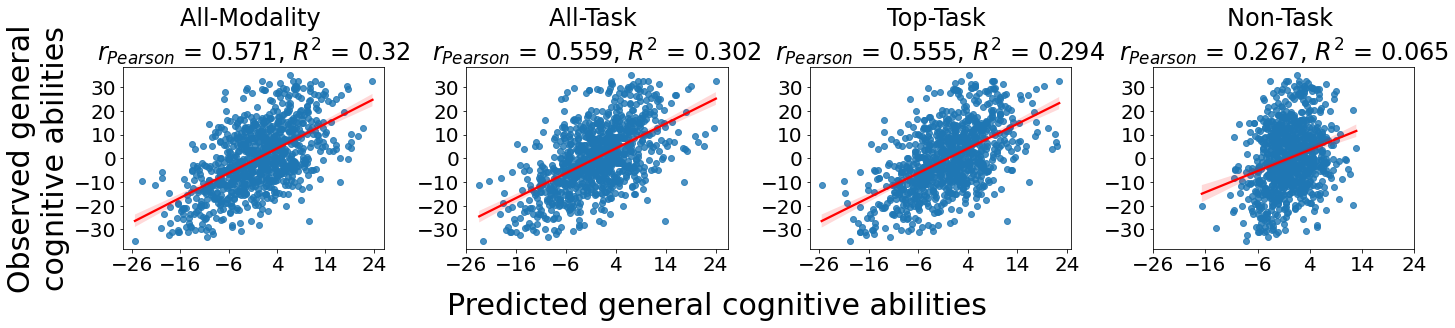

In [23]:
fig = plt.figure(figsize=(20,5))
#plt.suptitle('Relationship between observed and predicted general cognitive abilities \nbased on stacked models with eNet+eNet across eight held-out folds',fontsize=32)

df_y_all = dct_results['eNet+eNet']


plt.subplot(1,4,1)
col='all'
crr, _ = pearsonr(df_y_all['y_real'], df_y_all[col])
sns.regplot(x=col, y='y_real', data=df_y_all, fit_reg=True, line_kws={'color': 'red'}) 
plt.xticks(np.arange(-26, 26, 10), fontsize=20)
plt.yticks(fontsize=20)
#plt.xlabel('Predicted\ngeneral cognitive abilities', fontsize=21)
plt.xlabel(' ')
plt.ylabel('Observed general\ncognitive abilities', fontsize=30)
plt.title('All-Modality '+'\n'+'$r_{Pearson}$ = '+str(dct_cv_MEAN['eNet+eNet'].loc[col,'cor'].round(3))+
          ', $R^2$ = '+str(dct_cv_MEAN['eNet+eNet'].loc[col,'r2'].round(3)), fontsize=24)

plt.subplot(1,4,2)
col = 'task'  
crr, _ = pearsonr(df_y_all['y_real'], df_y_all[col])
sns.regplot(x=col, y='y_real', data=df_y_all, fit_reg=True, line_kws={'color': 'red'}) 
plt.xticks(np.arange(-26, 26, 10), fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(' ', fontsize=30)
#plt.ylabel('Observed\ngeneral cognitive abilities', fontsize=21)
plt.ylabel(' ')
plt.title('All-Task '+'\n'+'$r_{Pearson}$ = '+str(dct_cv_MEAN['eNet+eNet'].loc[col,'cor'].round(3))+
          ', $R^2$ = '+str(dct_cv_MEAN['eNet+eNet'].loc[col,'r2'].round(3)), fontsize=24)

plt.subplot(1,4,4)
col = 'non-task'
crr, _ = pearsonr(df_y_all['y_real'], df_y_all[col])
sns.regplot(x=col, y='y_real', data=df_y_all, fit_reg=True, line_kws={'color': 'red'}) 
plt.xticks(np.arange(-26, 26, 10), fontsize=20)
plt.yticks(fontsize=20)
#plt.xlabel('Predicted\ngeneral cognitive abilities', fontsize=21)
#plt.ylabel('Observed\ngeneral cognitive abilities', fontsize=21)  
plt.xlabel(' ')
plt.ylabel(' ')
plt.title('Non-Task '+'\n'+'$r_{Pearson}$ = '+str(dct_cv_MEAN['eNet+eNet'].loc[col,'cor'].round(3))+
          ', $R^2$ = '+str(dct_cv_MEAN['eNet+eNet'].loc[col,'r2'].round(3)), fontsize=24)

plt.subplot(1,4,3)
col = 'top-task'
crr, _ = pearsonr(df_y_all['y_real'], df_y_all[col])
sns.regplot(x=col, y='y_real', data=df_y_all, fit_reg=True, line_kws={'color': 'red'}) 
plt.xticks(np.arange(-26, 26, 10), fontsize=20)
plt.yticks(fontsize=20)
#plt.xlabel('Predicted\ngeneral cognitive abilities', fontsize=21)
#plt.ylabel('Observed\ngeneral cognitive abilities', fontsize=21)  
plt.xlabel(' ')
plt.ylabel(' ')
plt.title('Top-Task '+'\n'+'$r_{Pearson}$ = '+str(dct_cv_MEAN['eNet+eNet'].loc[col,'cor'].round(3))+
          ', $R^2$ = '+str(dct_cv_MEAN['eNet+eNet'].loc[col,'r2'].round(3)), fontsize=24)

#plt.supxlabel()
fig.supxlabel('Predicted general cognitive abilities', fontsize=30, y=0.1)
fig.tight_layout(pad=1.0)
plt.show()

##### reorganize tables for plotting

###### r2

In [25]:
#stack into one table for plot


dct_cv_plot_stacked_r2 = {}

for model in dct_cv_r2['eNet+eNet'].columns:


    #combine into one table by type of model
    v1 = []
    v2 = []
    dfdf = pd.DataFrame()
    for key in dct_cv_r2.keys():
        if model in dct_cv_r2['eNet+eNet'].columns[1:] and 'flat' not in key:
            if len(key.split('+')) >=2:
                v1 += [key.split('+')[0]]
                v2 += [key.split('+')[1]]
                dfdf[key] = dct_cv_r2[key][model]
        if dct_cv_r2['eNet+eNet'].columns[0] in model:
            if len(key.split('+')) >=2:
                v1 += [key.split('+')[0]]
                v2 += [key.split('+')[1]]
                dfdf[key] = dct_cv_r2[key][model]            

    V1=[]
    for i in v1:
        if i in ['svr', 'rf', 'xgb']:
            V1 += [i.upper()]
        else: 
            V1 += [i]    
    V2=[]
    for i in v2:
        if i in ['svr', 'rf', 'xgb']:
            V2 += [i.upper()]
        else: 
            V2 += [i]    

    #multi-index        
    collumnss = pd.MultiIndex.from_tuples(list(zip( V1,V2)), names=["single", "stack"])
    dfdf.columns=collumnss


    #reorganize table into long one for easy plotting

    dct_t2 = {}
    for col in dfdf.columns:
        nums = dfdf[col].values
        inds1 = np.full(len(dfdf[col].values), col[0])
        inds2 = np.full(len(dfdf[col].values), col[1])
        dct_t2[('_'.join(col))] = pd.DataFrame({'$R^2$': nums, 'Single Modality \nAlgorithm':inds1, 
                                                'Stacking Algorithm':inds2})

    #table for plot
    dfdf2 = dct_t2[sorted(dct_t2.keys())[0]]
    for key in sorted(dct_t2.keys())[1:]:
        dfdf2 = pd.concat([dfdf2, dct_t2[key]], axis=0, ignore_index=True)
    #display(dfdf2)

    dct_cv_plot_stacked_r2[model]=dfdf2

## CV plotting

###### CV stacked models

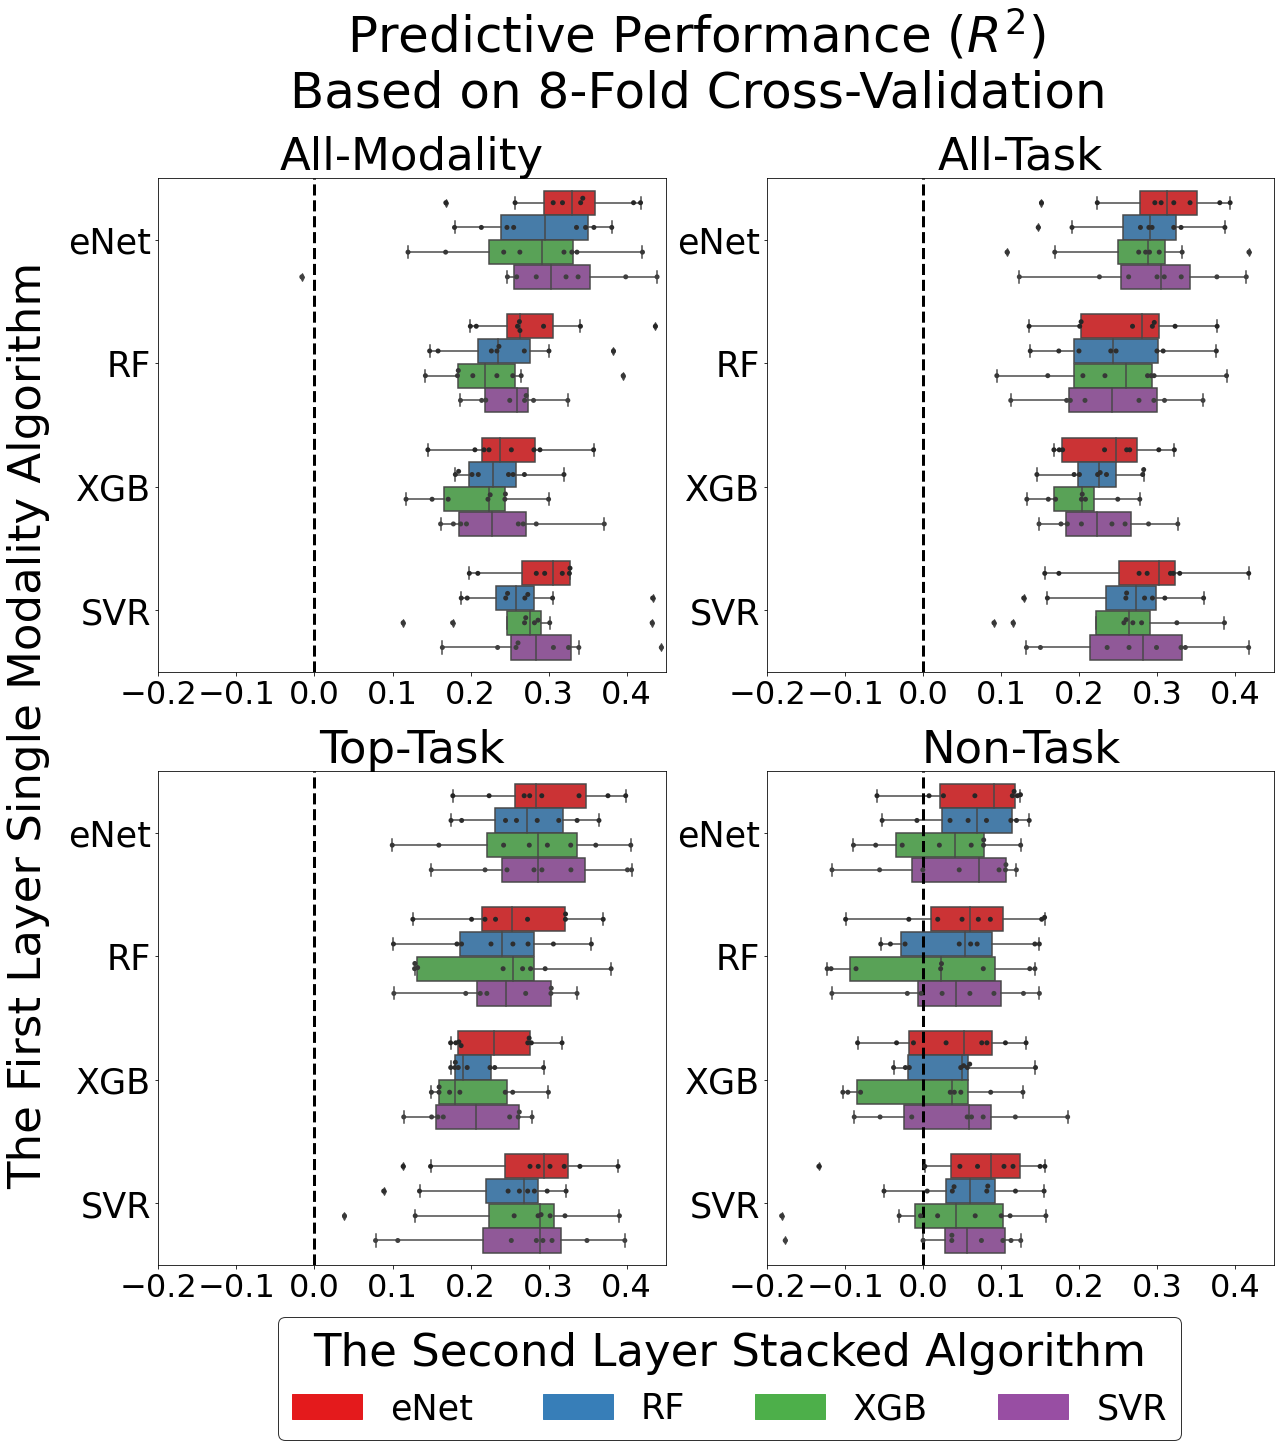

In [26]:
fig = plt.figure(figsize=(20,20))
plt.suptitle('Predictive Performance ($R^2$) \nBased on 8-Fold Cross-Validation',fontsize=50, x=0.5, y=0.999)

font1=28
font2=35
font3=45



plt.subplot(2,2,1)
plt.title('All-Modality', fontsize=45)
sns.boxplot(x='$R^2$', y='Single Modality \nAlgorithm', 
            hue='Stacking Algorithm', 
            data = dct_cv_plot_stacked_r2['all'][dct_cv_plot_stacked_r2['all']['Single Modality \nAlgorithm']!='flat'], 
            orient="h", palette=palette,
            order=['eNet', 'RF', 'XGB','SVR'], hue_order=['eNet', 'RF', 'XGB','SVR'])
sns.swarmplot(x='$R^2$', y='Single Modality \nAlgorithm', 
            hue='Stacking Algorithm', 
            data = dct_cv_plot_stacked_r2['all'][dct_cv_plot_stacked_r2['all']['Single Modality \nAlgorithm']!='flat'], 
            color=".25", orient="h", dodge=True,
            order=['eNet', 'RF', 'XGB','SVR'], hue_order=['eNet', 'RF', 'XGB','SVR'])

plt.legend([], [], frameon=False)

plt.xticks(fontsize=32) # 
plt.yticks(fontsize=35)
plt.xlabel('', fontsize=32)#plt.xlabel('$R^2$', fontsize=32)
plt.ylabel('', fontsize=21)
plt.xlim((-0.2, 0.45))
plt.axvline(0, color='black', linestyle='dashed', linewidth=3)



plt.subplot(2,2,2)
plt.title('All-Task', fontsize=45)
sns.boxplot(x='$R^2$', y='Single Modality \nAlgorithm', 
            hue='Stacking Algorithm', 
            data = dct_cv_plot_stacked_r2['task'][dct_cv_plot_stacked_r2['task']['Single Modality \nAlgorithm']!='flat'], 
            orient="h", palette=palette,
            order=['eNet', 'RF', 'XGB','SVR'], hue_order=['eNet', 'RF', 'XGB','SVR'])
sns.swarmplot(x='$R^2$', y='Single Modality \nAlgorithm', 
            hue='Stacking Algorithm', 
            data = dct_cv_plot_stacked_r2['task'][dct_cv_plot_stacked_r2['task']['Single Modality \nAlgorithm']!='flat'], 
            color=".25", orient="h", dodge=True,
            order=['eNet', 'RF', 'XGB','SVR'], hue_order=['eNet', 'RF', 'XGB','SVR'])

plt.legend([], [], frameon=False)

plt.xticks(fontsize=32) # 
plt.yticks(fontsize=35)
plt.xlabel('', fontsize=32)#plt.xlabel('$R^2$', fontsize=32)
plt.ylabel('', fontsize=21)#plt.ylabel('Modalities', fontsize=21)
plt.xlim((-0.2, 0.45))
plt.axvline(0, color='black', linestyle='dashed', linewidth=3)



plt.subplot(2,2,4)
plt.title('Non-Task', fontsize=45)
sns.boxplot(x='$R^2$', y='Single Modality \nAlgorithm', 
            hue='Stacking Algorithm', 
            data = dct_cv_plot_stacked_r2['non-task'][dct_cv_plot_stacked_r2['non-task']['Single Modality \nAlgorithm']!='flat'], 
            orient="h", palette=palette,
            order=['eNet', 'RF', 'XGB','SVR'], hue_order=['eNet', 'RF', 'XGB','SVR'])
sns.swarmplot(x='$R^2$', y='Single Modality \nAlgorithm', 
            hue='Stacking Algorithm', 
            data = dct_cv_plot_stacked_r2['non-task'][dct_cv_plot_stacked_r2['non-task']['Single Modality \nAlgorithm']!='flat'], 
            color=".25", orient="h", dodge=True,
            order=['eNet', 'RF', 'XGB','SVR'], hue_order=['eNet', 'RF', 'XGB','SVR'])

plt.legend(handles=[mpatches.Patch(color=sns.color_palette("Set1")[0], label='eNet'), 
                    mpatches.Patch(color=sns.color_palette("Set1")[1], label='RF'), 
                    mpatches.Patch(color=sns.color_palette("Set1")[2], label='XGB'), 
                    mpatches.Patch(color=sns.color_palette("Set1")[3], label='SVR')], 
                    fontsize=font2, bbox_to_anchor=(0.85, -0.07), 
                    title="The Second Layer Stacked Algorithm", title_fontsize=font3, ncol=4, edgecolor='black')

plt.xticks(fontsize=32) # 
plt.yticks(fontsize=35)
plt.xlabel('', fontsize=32)#'$R^2$'
plt.ylabel('', fontsize=21)
plt.xlim((-0.2, 0.45))
plt.axvline(0, color='black', linestyle='dashed', linewidth=3)



plt.subplot(2,2,3)
plt.title('Top-Task', fontsize=45)
sns.boxplot(x='$R^2$', y='Single Modality \nAlgorithm', 
            hue='Stacking Algorithm',
            data = dct_cv_plot_stacked_r2['top-task'][dct_cv_plot_stacked_r2['top-task']['Single Modality \nAlgorithm']!='flat'], 
            orient="h", palette=palette,
            order=['eNet', 'RF', 'XGB','SVR'], hue_order=['eNet', 'RF', 'XGB','SVR'])
sns.swarmplot(x='$R^2$', y='Single Modality \nAlgorithm', 
            hue='Stacking Algorithm', 
            data = dct_cv_plot_stacked_r2['top-task'][dct_cv_plot_stacked_r2['top-task']['Single Modality \nAlgorithm']!='flat'], 
            color=".25", orient="h", dodge=True,
            order=['eNet', 'RF', 'XGB','SVR'], hue_order=['eNet', 'RF', 'XGB','SVR'])
plt.legend([], [], frameon=False)


plt.xticks(fontsize=32) # 
plt.yticks(fontsize=35)
plt.xlabel('', fontsize=32)
plt.ylabel('', fontsize=21)#plt.ylabel('Modalities', fontsize=21)
plt.xlim((-0.2, 0.45))
plt.axvline(0, color='black', linestyle='dashed', linewidth=3)

fig.supylabel('The First Layer Single Modality Algorithm', fontsize=45)
#fig.tight_layout(h_pad=2, w_pad=-45)
plt.show()

###### CV single modality models

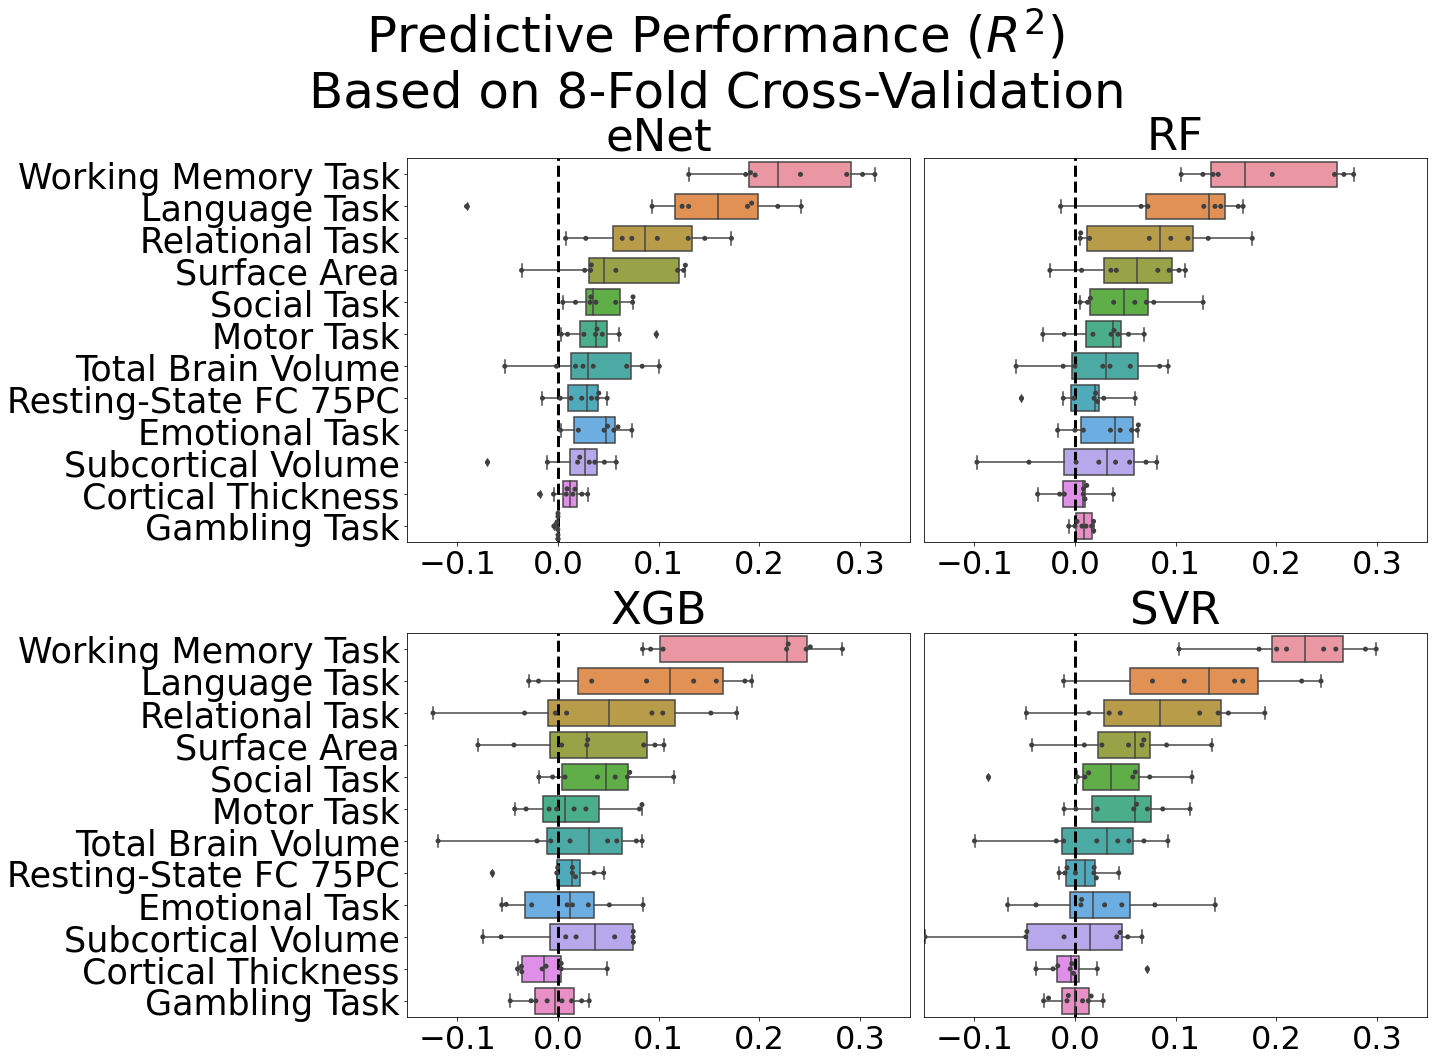

In [27]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


fig = plt.figure(figsize=(20,15))
plt.suptitle('Predictive Performance ($R^2$) \nBased on 8-Fold Cross-Validation',fontsize=50)#, x=0.5, y=1.02



font1=28
font2=35
font3=45

lims=(-0.15, 0.35)



col_ord=dct_cv_r2['eNet'].mean().sort_values(ascending=False).index

lblY = ['Working Memory Task',
'Language Task',
'Relational Task',    
'Surface Area',    
'Social Task',    
'Motor Task',     
'Total Brain Volume',
'Resting-State FC 75PC',
'Emotional Task',
'Subcortical Volume',        
'Cortical Thickness',            
'Gambling Task']




plt.subplot(2,2,2)
plt.title('RF', fontsize=45)
sns.boxplot(data = dct_cv_r2['rf'].reindex(columns=col_ord), 
            orient="h")
sns.swarmplot(data = dct_cv_r2['rf'].reindex(columns=col_ord), 
              color=".25", orient="h", dodge=True)

plt.legend([], [], frameon=False)

plt.xticks([-0.1,0,0.1,0.2,0.3],fontsize=32) # 
plt.yticks([], fontsize=35)
plt.xlabel('')#plt.xlabel('$R^2$', fontsize=32)
plt.ylabel('')
plt.xlim(lims)
plt.axvline(0, color='black', linestyle='dashed', linewidth=3)



plt.subplot(2,2,4)
plt.title('SVR', fontsize=45)
sns.boxplot(data = dct_cv_r2['svr'].reindex(columns=col_ord), 
            orient="h")
sns.swarmplot(data = dct_cv_r2['svr'].reindex(columns=col_ord), 
              color=".25", orient="h", dodge=True)

plt.legend([], [], frameon=False)

plt.xticks([-0.1,0,0.1,0.2,0.3],fontsize=32) # 
plt.yticks([],fontsize=35)
plt.xlabel('')#plt.xlabel('$R^2$', fontsize=32)
plt.ylabel('')#plt.ylabel('Modalities', fontsize=21)
plt.xlim(lims)
plt.axvline(0, color='black', linestyle='dashed', linewidth=3)



plt.subplot(2,2,3)
plt.title('XGB', fontsize=45)
sns.boxplot(data = dct_cv_r2['xgb'].reindex(columns=col_ord), 
            orient="h")
sns.swarmplot(data = dct_cv_r2['xgb'].reindex(columns=col_ord), 
              color=".25", orient="h", dodge=True)

plt.legend([], [], frameon=False)

plt.xticks([-0.1,0,0.1,0.2,0.3],fontsize=32) # 
plt.yticks(np.arange(12), lblY, fontsize=35)
plt.xlabel('')#'$R^2$'
plt.ylabel('')
plt.xlim(lims)
plt.axvline(0, color='black', linestyle='dashed', linewidth=3)



plt.subplot(2,2,1)
plt.title('eNet', fontsize=45)
sns.boxplot(data = dct_cv_r2['eNet'].reindex(columns=col_ord), 
            orient="h")
sns.swarmplot(data = dct_cv_r2['eNet'].reindex(columns=col_ord), 
              color=".25", orient="h", dodge=True)
plt.legend([], [], frameon=False)

plt.xticks([-0.1,0,0.1,0.2,0.3],fontsize=32) # 
plt.yticks(np.arange(12), lblY, fontsize=35)
plt.xlabel('')
plt.ylabel('')#plt.ylabel('Modalities', fontsize=21)
plt.xlim(lims)
plt.axvline(0, color='black', linestyle='dashed', linewidth=3)

#fig.supylabel('The First Layer Single Modality Algorithm \n \n \n ', fontsize=50, x=-0.06, y=0.5)
fig.tight_layout(pad=1)
plt.show()

# Bootstrapped difference between "eNet-eNet" All-modality stacked model and others models/algorithms

In [28]:
# r2

#calculate difference between All Mods stacked model (set1) and others
#empty dict for storing results
dct_diff_alg = {}
dct_diff_stack = {}
dct_diff_singl = {}

#doing subtraction
#for algorithms
for key in list(dct_bootstrap_r2.keys())[1:]:
    if len(key.split('+')) >=2:
        dct_diff_alg[('eNet+eNet' + '__-__' + key)] = dct_bootstrap_r2['eNet+eNet']['all'] - dct_bootstrap_r2[key]['all']

#for stacking models in 'eNet+eNet'
for col in dct_bootstrap_r2['eNet+eNet'].columns[1:]:
    dct_diff_stack['all' + '_-_' + col] = dct_bootstrap_r2['eNet+eNet']['all'] - dct_bootstrap_r2['eNet+eNet'][col]

#for single models in 'eNet' and 'eNet+eNet'
for col in dct_bootstrap_r2['eNet'].columns:
    dct_diff_singl['all' + '_-_' + col] = dct_bootstrap_r2['eNet+eNet']['all'] - dct_bootstrap_r2['eNet'][col]

    

#transform dict to tables
diff_alg = pd.DataFrame(dct_diff_alg)
diff_stack = pd.DataFrame(dct_diff_stack)
diff_singl = pd.DataFrame(dct_diff_singl)


In [29]:
# mse

#calculate difference between All Mods stacked model (set1) and others
#empty dict for storing results
dct_diff_alg_mse = {}
dct_diff_stack_mse = {}
dct_diff_singl_mse = {}

#doing subtraction
#for algorithms
for key in list(dct_bootstrap_mse.keys())[1:]:
    if len(key.split('+')) >=2:
        dct_diff_alg_mse[('eNet+eNet' + '__-__' + key)] = dct_bootstrap_mse['eNet+eNet']['all'] - dct_bootstrap_mse[key]['all']

#for stacking models in 'eNet+eNet'
for col in dct_bootstrap_mse['eNet+eNet'].columns[1:]:
    dct_diff_stack_mse['all' + '_-_' + col] = dct_bootstrap_mse['eNet+eNet']['all'] - dct_bootstrap_mse['eNet+eNet'][col]

#for single models in 'eNet' and 'eNet+eNet'
for col in dct_bootstrap_mse['eNet'].columns:
    dct_diff_singl_mse['all' + '_-_' + col] = dct_bootstrap_mse['eNet+eNet']['all'] - dct_bootstrap_mse['eNet'][col]

    

#transform dict to tables
diff_alg_mse = pd.DataFrame(dct_diff_alg_mse)
diff_stack_mse = pd.DataFrame(dct_diff_stack_mse)
diff_singl_mse = pd.DataFrame(dct_diff_singl_mse)


In [30]:
#mae

#calculate difference between All Mods stacked model (set1) and others
#empty dict for storing results
dct_diff_alg_mae = {}
dct_diff_stack_mae = {}
dct_diff_singl_mae = {}

#doing subtraction
#for algorithms
for key in list(dct_bootstrap_mae.keys())[1:]:
    if len(key.split('+')) >=2:
        dct_diff_alg_mae[('eNet+eNet' + '__-__' + key)] = dct_bootstrap_mae['eNet+eNet']['all'] - dct_bootstrap_mae[key]['all']

#for stacking models in 'eNet+eNet'
for col in dct_bootstrap_mae['eNet+eNet'].columns[1:]:
    dct_diff_stack_mae['all' + '_-_' + col] = dct_bootstrap_mae['eNet+eNet']['all'] - dct_bootstrap_mae['eNet+eNet'][col]

#for single models in 'eNet' and 'eNet+eNet'
for col in dct_bootstrap_mae['eNet'].columns:
    dct_diff_singl_mae['all' + '_-_' + col] = dct_bootstrap_mae['eNet+eNet']['all'] - dct_bootstrap_mae['eNet'][col]

    

#transform dict to tables
diff_alg_mae = pd.DataFrame(dct_diff_alg_mae)
diff_stack_mae = pd.DataFrame(dct_diff_stack_mae)
diff_singl_mae = pd.DataFrame(dct_diff_singl_mae)


In [31]:
#cor

#calculate difference between All Mods stacked model (set1) and others
#empty dict for storing results
dct_diff_alg_cor = {}
dct_diff_stack_cor = {}
dct_diff_singl_cor = {}

#doing subtraction
#for algorithms
for key in list(dct_bootstrap_cor.keys())[1:]:
    if len(key.split('+')) >=2:
        dct_diff_alg_cor[('eNet+eNet' + '__-__' + key)] = dct_bootstrap_cor['eNet+eNet']['all'] - dct_bootstrap_cor[key]['all']

#for stacking models in 'eNet+eNet'
for col in dct_bootstrap_cor['eNet+eNet'].columns[1:]:
    dct_diff_stack_cor['all' + '_-_' + col] = dct_bootstrap_cor['eNet+eNet']['all'] - dct_bootstrap_cor['eNet+eNet'][col]

#for single models in 'eNet' and 'eNet+eNet'
for col in dct_bootstrap_cor['eNet'].columns:
    dct_diff_singl_cor['all' + '_-_' + col] = dct_bootstrap_cor['eNet+eNet']['all'] - dct_bootstrap_cor['eNet'][col]

    

#transform dict to tables
diff_alg_cor = pd.DataFrame(dct_diff_alg_cor)
diff_stack_cor = pd.DataFrame(dct_diff_stack_cor)
diff_singl_cor = pd.DataFrame(dct_diff_singl_cor)


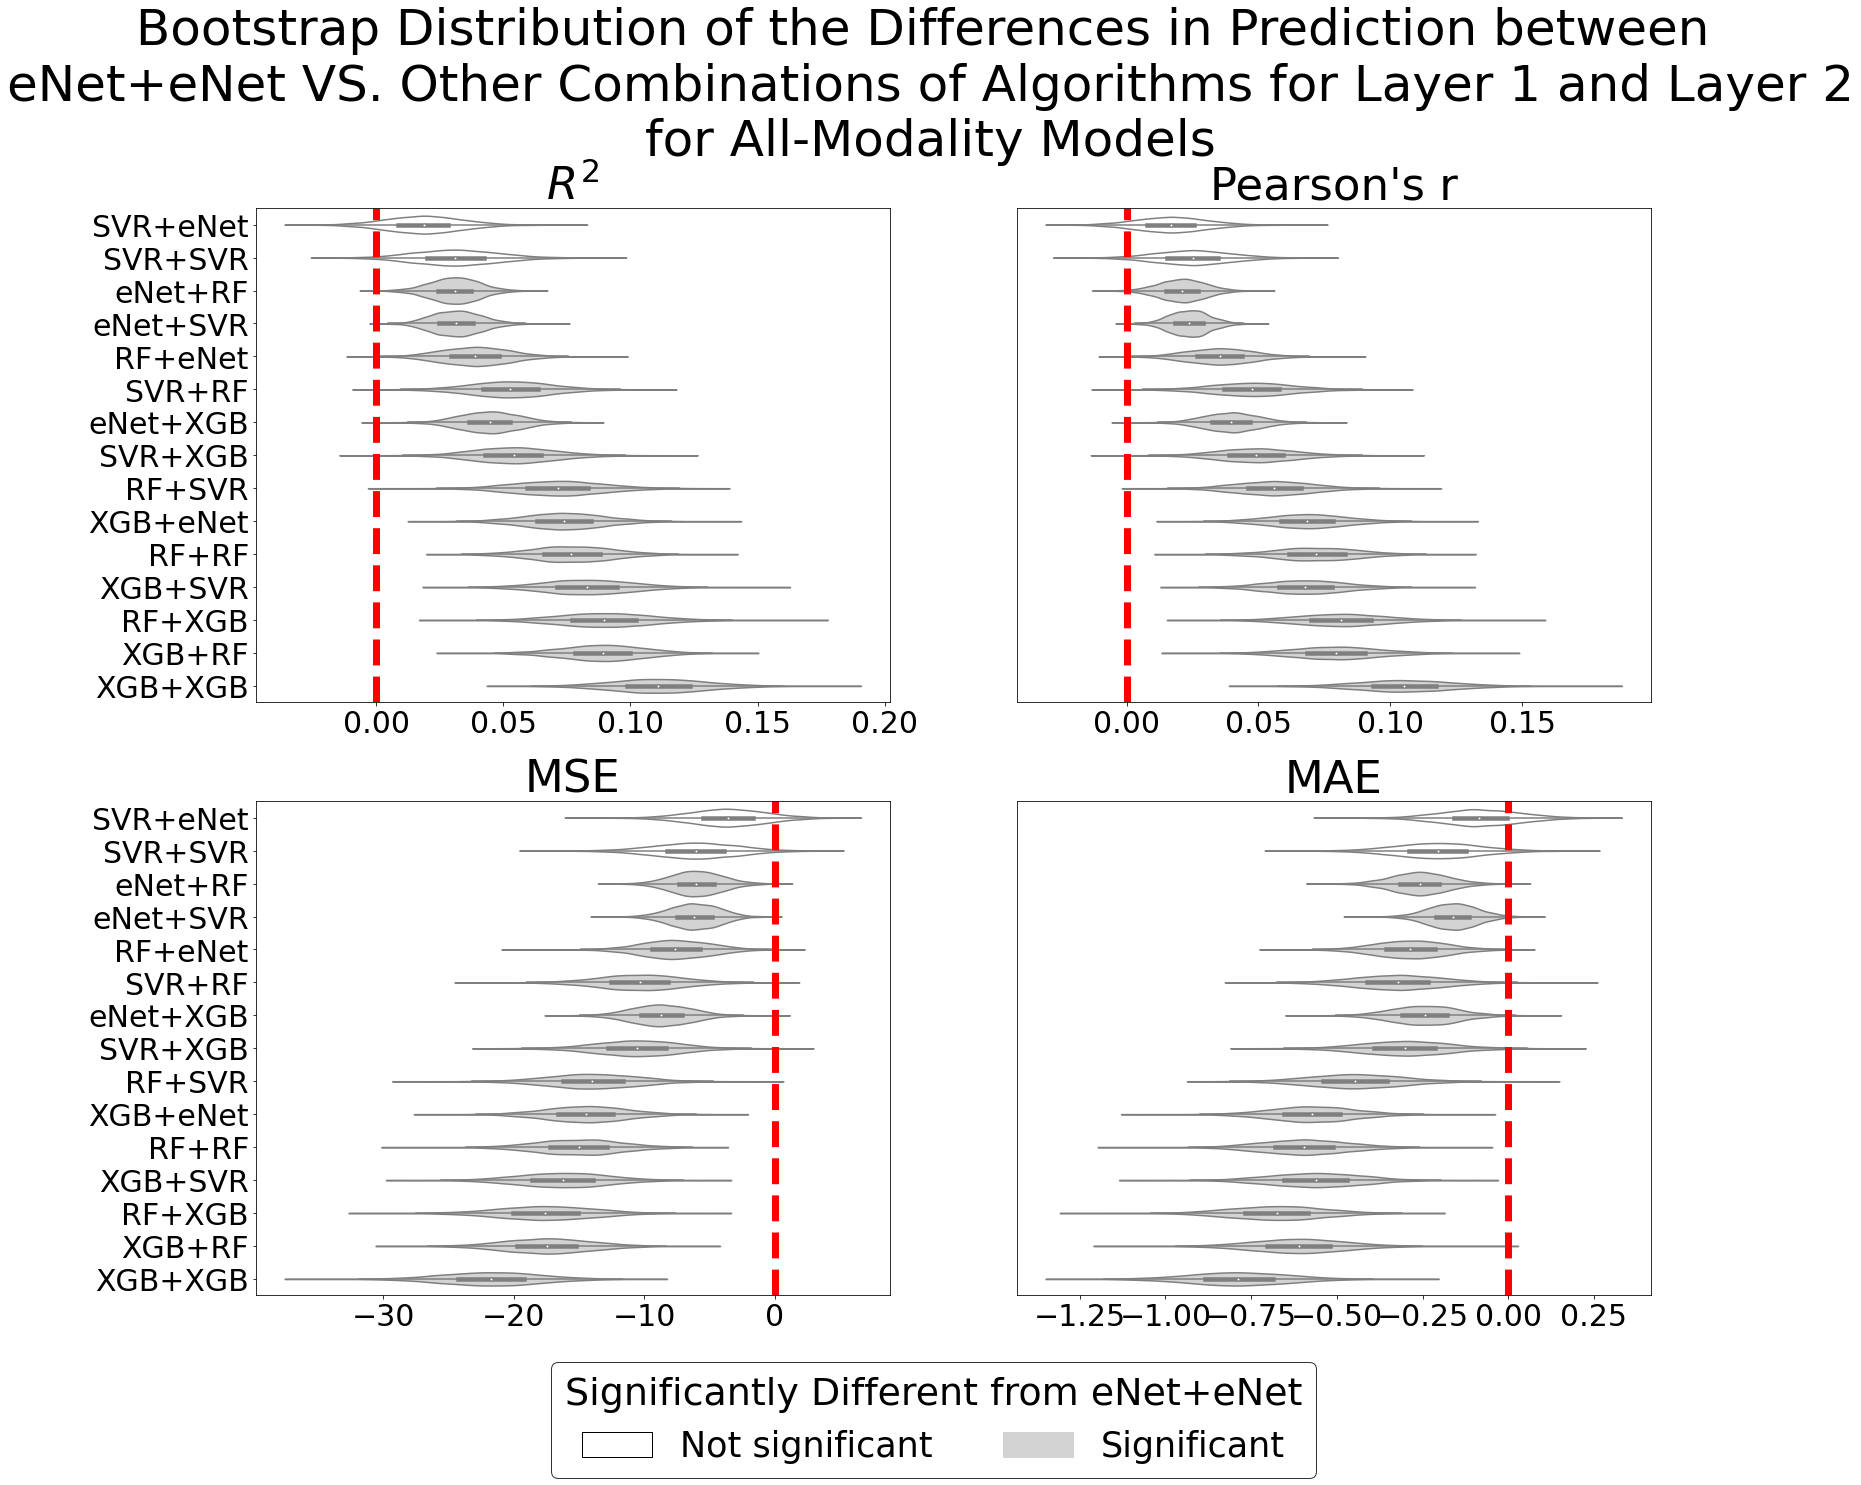

In [32]:
fig = plt.figure(figsize=(25,20))

plt.suptitle('Bootstrap Distribution of the Differences in Prediction between \neNet+eNet VS. Other Combinations of Algorithms for Layer 1 and Layer 2\nfor All-Modality Models',
         fontsize=50, y=1.02)

#dataset for r2
dataset = diff_alg.reindex(columns=[col for col in diff_alg.columns if 'flat' not in col])

CI1, CI2, colss = [],[], []
for col in dataset:
    CI1 += [(st.t.interval(alpha=0.95, df=len(dataset[col])-1, loc=np.mean(dataset[col]), scale=np.std(dataset[col])))[0]]
    CI2 += [(st.t.interval(alpha=0.95, df=len(dataset[col])-1, loc=np.mean(dataset[col]), scale=np.std(dataset[col])))[1]]
    colss += [col]
df_CI1 = pd.DataFrame({'CI1':CI1, 'CI2':CI2}, index=colss).sort_values(by='CI1', ascending=True)

dataset = dataset.reindex(columns=df_CI1.index)


#other indexes datasets
dataset_mse = diff_alg_mse.reindex(columns=df_CI1.index)
dataset_mae = diff_alg_mae.reindex(columns=df_CI1.index)
dataset_cor = diff_alg_cor.reindex(columns=df_CI1.index)

#CI for other datasets indexes (mse, mae, cor)
dct_ci_othinxs={}
algs=['mse', 'mae', 'cor']
c=0
for dtst in [dataset_mse, dataset_mae, dataset_cor]:
    CI1, CI2, colss = [],[], []
    for col in dtst:
        CI1 += [(st.t.interval(alpha=0.95, df=len(dtst[col])-1, loc=np.mean(dtst[col]), scale=np.std(dtst[col])))[0]]
        CI2 += [(st.t.interval(alpha=0.95, df=len(dtst[col])-1, loc=np.mean(dtst[col]), scale=np.std(dtst[col])))[1]]
        colss += [col]
    dct_ci_othinxs[algs[c]]= pd.DataFrame({'CI1':CI1, 'CI2':CI2}, index=colss).sort_values(by='CI1', ascending=True)
    c+=1


#labels for y-axis
ylabl = [col.split('__-__')[1] for col in dataset.columns]

ylabl1=[]
for i in ylabl:
    j = i.split('+')
    if j[0] != 'eNet':
        j[0]=j[0].upper()
    if j[1] != 'eNet':
        j[1]=j[1].upper() 
    ylabl1 += [('+'.join(j))]




        
###plot r2  

plt.subplot(2,2,1)

plt.title("$R^2$", fontsize=45)

#color pallete r2
my_pal = {}
for ind in df_CI1.index:
    if df_CI1.loc[ind, 'CI1'] <=0:
        my_pal[ind] = 'white'
    else:
        my_pal[ind] = 'lightgray'

sns.violinplot(data=dataset, orient='h', palette=my_pal)

plt.axvline(0, color='r', linestyle='dashed', linewidth=7)
#mod=2
#plt.axvline(df_CI1.iloc[mod,0], color='black', linestyle='dashed', linewidth=1)
#plt.axvline(df_CI1.iloc[mod,1], color='black', linestyle='dashed', linewidth=1)
plt.yticks(np.arange(len(ylabl1)), ylabl1, fontsize=30)
plt.xticks(fontsize=30)


###plot mse

plt.subplot(2,2,3)

plt.title("MSE", fontsize=45)

#color pallete mse
my_pal2 = {}
for ind in dct_ci_othinxs['mse'].index:
    if dct_ci_othinxs['mse'].loc[ind, 'CI2'] >=0:
        my_pal2[ind] = 'white'
    else:
        my_pal2[ind] = 'lightgray'

sns.violinplot(data=dataset_mse, orient='h', palette=my_pal2)

#mod=dct_ci_othinxs['mse'].sort_values(by='CI2', ascending=False).index[2]
#plt.axvline(dct_ci_othinxs['mse'].loc[mod,'CI1'], color='black', linestyle='dashed', linewidth=1)
#plt.axvline(dct_ci_othinxs['mse'].loc[mod,'CI2'], color='black', linestyle='dashed', linewidth=1)

plt.axvline(0, color='r', linestyle='dashed', linewidth=7)
plt.yticks(np.arange(len(ylabl1)), ylabl1, fontsize=30)
plt.xticks(fontsize=30)


###plot mae

plt.subplot(2,2,4)

plt.title("MAE", fontsize=45)

#color pallete mae
my_pal3 = {}
for ind in dct_ci_othinxs['mae'].index:
    if dct_ci_othinxs['mae'].loc[ind, 'CI2'] >=0:
        my_pal3[ind] = 'white'
    else:
        my_pal3[ind] = 'lightgray'

sns.violinplot(data=dataset_mae, orient='h', palette=my_pal3)

#mod=dct_ci_othinxs['mae'].sort_values(by='CI2', ascending=False).index[2]
#plt.axvline(dct_ci_othinxs['mae'].loc[mod,'CI1'], color='black', linestyle='dashed', linewidth=1)
#plt.axvline(dct_ci_othinxs['mae'].loc[mod,'CI2'], color='black', linestyle='dashed', linewidth=1)

plt.axvline(0, color='r', linestyle='dashed', linewidth=7)
plt.yticks([])
plt.xticks(fontsize=30)

plt.legend(handles=[mpatches.Patch(edgecolor='black', facecolor='white',  label='Not significant'), 
                    mpatches.Patch(color='lightgray', label='Significant')], 
                    fontsize=35, bbox_to_anchor=(0.5, -0.1), 
                    title="Significantly Different from eNet+eNet", 
           title_fontsize=38, ncol=2, edgecolor='black')


###plot cor

plt.subplot(2,2,2)

plt.title("Pearson's r", fontsize=45)

#color pallete mae
my_pal4 = {}
for ind in dct_ci_othinxs['cor'].index:
    if dct_ci_othinxs['cor'].loc[ind, 'CI1'] <=0:
        my_pal4[ind] = 'white'
    else:
        my_pal4[ind] = 'lightgray'

sns.violinplot(data=dataset_cor, orient='h', palette=my_pal4)

#mod=dct_ci_othinxs['cor'].sort_values(by='CI1', ascending=True).index[2]
#plt.axvline(dct_ci_othinxs['cor'].loc[mod,'CI1'], color='black', linestyle='dashed', linewidth=1)
#plt.axvline(dct_ci_othinxs['cor'].loc[mod,'CI2'], color='black', linestyle='dashed', linewidth=1)

plt.axvline(0, color='r', linestyle='dashed', linewidth=7)
plt.yticks([])
plt.xticks(fontsize=30)




#fig.tight_layout()

plt.show()

In [33]:
df_CI1 #r2

,CI1,CI2
eNet+eNet__-__svr+eNet,-0.010387,0.047403
eNet+eNet__-__svr+svr,-0.001165,0.063514
eNet+eNet__-__eNet+rf,0.011581,0.049613
eNet+eNet__-__eNet+svr,0.012375,0.050775
eNet+eNet__-__rf+eNet,0.012426,0.065228
eNet+eNet__-__svr+rf,0.020955,0.084445
eNet+eNet__-__eNet+xgb,0.021137,0.067945
eNet+eNet__-__svr+xgb,0.022035,0.086109
eNet+eNet__-__rf+svr,0.036965,0.106157
eNet+eNet__-__xgb+eNet,0.043049,0.104677


In [34]:
dct_ci_othinxs['mse'].sort_values(by='CI2', ascending=False)

,CI1,CI2
eNet+eNet__-__svr+eNet,-9.266683,2.025784
eNet+eNet__-__svr+svr,-12.383413,0.193187
eNet+eNet__-__eNet+rf,-9.871414,-2.155153
eNet+eNet__-__rf+eNet,-12.786934,-2.426079
eNet+eNet__-__eNet+svr,-9.864307,-2.482213
eNet+eNet__-__svr+rf,-16.692881,-3.989247
eNet+eNet__-__eNet+xgb,-13.292750,-4.148439
eNet+eNet__-__svr+xgb,-16.908338,-4.280883
eNet+eNet__-__rf+svr,-20.691952,-7.313212
eNet+eNet__-__xgb+eNet,-20.573333,-8.371016


In [35]:
dct_ci_othinxs['mae'].sort_values(by='CI2', ascending=False)

,CI1,CI2
eNet+eNet__-__svr+eNet,-0.308257,0.143635
eNet+eNet__-__svr+svr,-0.449761,0.036304
eNet+eNet__-__eNet+svr,-0.303576,-0.022160
eNet+eNet__-__svr+xgb,-0.560675,-0.043339
eNet+eNet__-__eNet+xgb,-0.434498,-0.054178
eNet+eNet__-__svr+rf,-0.575465,-0.070882
eNet+eNet__-__rf+eNet,-0.489458,-0.082045
eNet+eNet__-__eNet+rf,-0.421554,-0.096381
eNet+eNet__-__rf+svr,-0.709380,-0.185490
eNet+eNet__-__xgb+svr,-0.826068,-0.300197


In [36]:
dct_ci_othinxs['cor'].sort_values(by='CI1', ascending=True)

,CI1,CI2
eNet+eNet__-__svr+eNet,-0.009278,0.042888
eNet+eNet__-__svr+svr,-0.002706,0.053023
eNet+eNet__-__eNet+rf,0.003669,0.038381
eNet+eNet__-__eNet+svr,0.008969,0.038651
eNet+eNet__-__rf+eNet,0.010862,0.059880
eNet+eNet__-__svr+rf,0.017040,0.078227
eNet+eNet__-__eNet+xgb,0.018861,0.060235
eNet+eNet__-__svr+xgb,0.019824,0.078549
eNet+eNet__-__rf+svr,0.027467,0.084561
eNet+eNet__-__xgb+svr,0.038472,0.097049


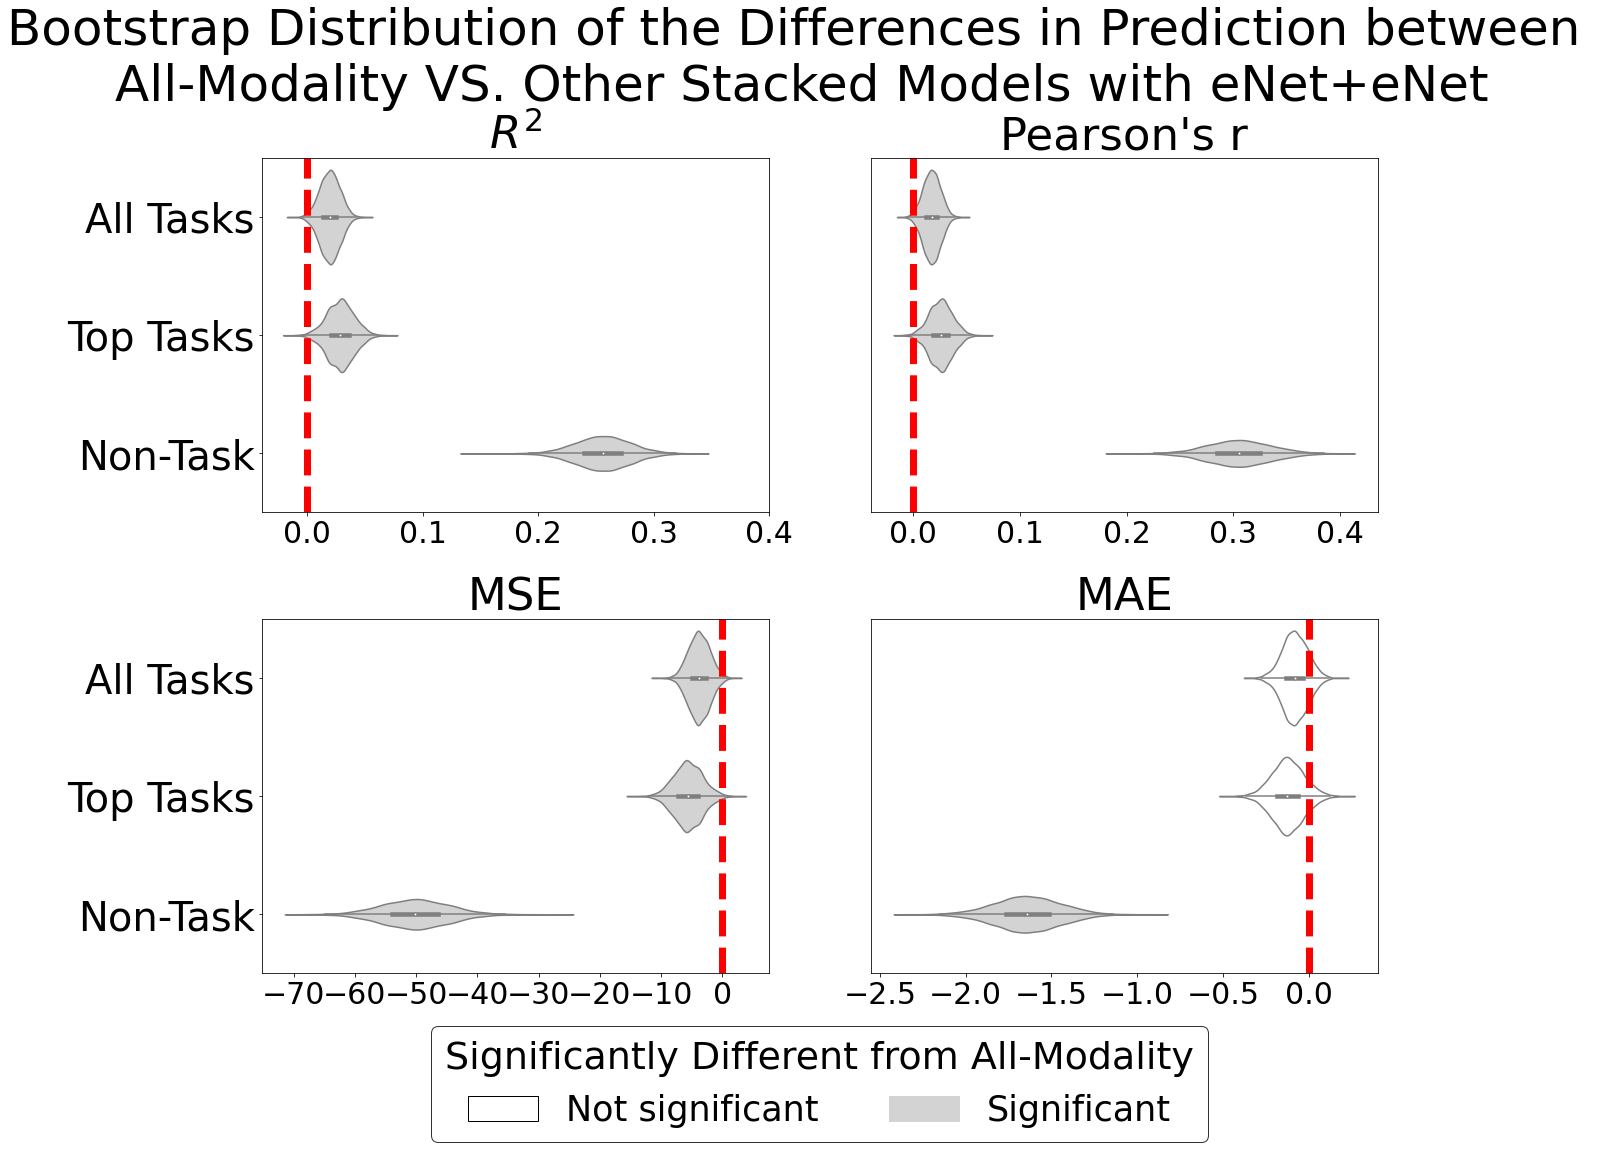

In [53]:
fig = plt.figure(figsize=(20,15))

plt.suptitle('Bootstrap Distribution of the Differences in Prediction between \nAll-Modality VS. Other Stacked Models with eNet+eNet',
         fontsize=50, y=1.02)

#dataset for r2
dataset = diff_stack.reindex(columns=[col for col in diff_stack.columns if 'flat' not in col])

CI1, CI2, colss = [],[], []
for col in dataset:
    CI1 += [(st.t.interval(alpha=0.95, df=len(dataset[col])-1, loc=np.mean(dataset[col]), scale=np.std(dataset[col])))[0]]
    CI2 += [(st.t.interval(alpha=0.95, df=len(dataset[col])-1, loc=np.mean(dataset[col]), scale=np.std(dataset[col])))[1]]
    colss += [col]
df_CI2 = pd.DataFrame({'CI1':CI1, 'CI2':CI2}, index=colss).sort_values(by='CI1', ascending=True)

dataset = dataset.reindex(columns=df_CI2.index)


#other indexes datasets
dataset_mse = diff_stack_mse.reindex(columns=df_CI2.index)
dataset_mae = diff_stack_mae.reindex(columns=df_CI2.index)
dataset_cor = diff_stack_cor.reindex(columns=df_CI2.index)

#CI for other datasets indexes (mse, mae, cor)
dct_ci_othinxs2={}
algs=['mse', 'mae', 'cor']
c=0
for dtst in [dataset_mse, dataset_mae, dataset_cor]:
    CI1, CI2, colss = [],[], []
    for col in dtst:
        CI1 += [(st.t.interval(alpha=0.95, df=len(dtst[col])-1, loc=np.mean(dtst[col]), scale=np.std(dtst[col])))[0]]
        CI2 += [(st.t.interval(alpha=0.95, df=len(dtst[col])-1, loc=np.mean(dtst[col]), scale=np.std(dtst[col])))[1]]
        colss += [col]
    dct_ci_othinxs2[algs[c]]= pd.DataFrame({'CI1':CI1, 'CI2':CI2}, index=colss).sort_values(by='CI1', ascending=True)
    c+=1


#labels for y-axis
ylabl = ['All Tasks',
        'Top Tasks',
        'Non-Task']

        
###plot r2  

plt.subplot(2,2,1)

plt.title("$R^2$", fontsize=45)

#color pallete r2
my_pal = {}
for ind in df_CI2.index:
    if df_CI2.loc[ind, 'CI1'] <=0:
        my_pal[ind] = 'white'
    else:
        my_pal[ind] = 'lightgray'

sns.violinplot(data=dataset, orient='h', palette=my_pal)

plt.axvline(0, color='r', linestyle='dashed', linewidth=7)
#mod=0
#plt.axvline(df_CI2.iloc[mod,0], color='black', linestyle='dashed', linewidth=1)
#plt.axvline(df_CI2.iloc[mod,1], color='black', linestyle='dashed', linewidth=1)
plt.yticks(np.arange(len(ylabl)), ylabl, fontsize=40)
plt.xticks([0,0.1,0.2,0.3,0.4],fontsize=30)


###plot mse

plt.subplot(2,2,3)

plt.title("MSE", fontsize=45)

#color pallete mse
my_pal2 = {}
for ind in dct_ci_othinxs2['mse'].index:
    if dct_ci_othinxs2['mse'].loc[ind, 'CI2'] >=0:
        my_pal2[ind] = 'white'
    else:
        my_pal2[ind] = 'lightgray'

sns.violinplot(data=dataset_mse, orient='h', palette=my_pal2)

#mod=dct_ci_othinxs2['mse'].sort_values(by='CI2', ascending=False).index[0]
#plt.axvline(dct_ci_othinxs2['mse'].loc[mod,'CI1'], color='black', linestyle='dashed', linewidth=1)
#plt.axvline(dct_ci_othinxs2['mse'].loc[mod,'CI2'], color='black', linestyle='dashed', linewidth=1)

plt.axvline(0, color='r', linestyle='dashed', linewidth=7)
plt.yticks(np.arange(len(ylabl)), ylabl, fontsize=40)
plt.xticks(fontsize=30)


###plot mae

plt.subplot(2,2,4)

plt.title("MAE", fontsize=45)

#color pallete mae
my_pal3 = {}
for ind in dct_ci_othinxs2['mae'].index:
    if dct_ci_othinxs2['mae'].loc[ind, 'CI2'] >=0:
        my_pal3[ind] = 'white'
    else:
        my_pal3[ind] = 'lightgray'

sns.violinplot(data=dataset_mae, orient='h', palette=my_pal3)

#mod=dct_ci_othinxs2['mae'].sort_values(by='CI2', ascending=False).index[2]
#plt.axvline(dct_ci_othinxs2['mae'].loc[mod,'CI1'], color='black', linestyle='dashed', linewidth=1)
#plt.axvline(dct_ci_othinxs2['mae'].loc[mod,'CI2'], color='black', linestyle='dashed', linewidth=1)

plt.axvline(0, color='r', linestyle='dashed', linewidth=7)
plt.yticks([])
plt.xticks(fontsize=30)

plt.legend(handles=[mpatches.Patch(edgecolor='black', facecolor='white',  label='Not significant'), 
                    mpatches.Patch(color='lightgray', label='Significant')], 
                    fontsize=35, bbox_to_anchor=(0.7, -0.1), 
                    title="Significantly Different from All-Modality", 
           title_fontsize=38, ncol=2, edgecolor='black')
###plot cor

plt.subplot(2,2,2)

plt.title("Pearson's r", fontsize=45)

#color pallete mae
my_pal4 = {}
for ind in dct_ci_othinxs2['cor'].index:
    if dct_ci_othinxs2['cor'].loc[ind, 'CI1'] <=0:
        my_pal4[ind] = 'white'
    else:
        my_pal4[ind] = 'lightgray'

sns.violinplot(data=dataset_cor, orient='h', palette=my_pal4)

#mod=dct_ci_othinxs2['cor'].sort_values(by='CI1', ascending=True).index[0]
#plt.axvline(dct_ci_othinxs2['cor'].loc[mod,'CI1'], color='black', linestyle='dashed', linewidth=1)
#plt.axvline(dct_ci_othinxs2['cor'].loc[mod,'CI2'], color='black', linestyle='dashed', linewidth=1)

plt.axvline(0, color='r', linestyle='dashed', linewidth=7)
plt.yticks([])
plt.xticks(fontsize=30)

#fig.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.show()

In [38]:
df_CI2 #r2

,CI1,CI2
all_-_task,0.002405,0.036775
all_-_top-task,0.005510,0.051881
all_-_non-task,0.208822,0.302782


In [39]:
dct_ci_othinxs2['mse']

,CI1,CI2
all_-_non-task,-60.934351,-39.407973
all_-_top-task,-10.256613,-1.017325
all_-_task,-7.274101,-0.427979


In [40]:
dct_ci_othinxs2['mae']

,CI1,CI2
all_-_non-task,-2.020608,-1.264563
all_-_top-task,-0.308100,0.061314
all_-_task,-0.226635,0.062779


In [41]:
dct_ci_othinxs2['cor']

,CI1,CI2
all_-_task,0.001331,0.033328
all_-_top-task,0.004195,0.047420
all_-_non-task,0.246852,0.363858


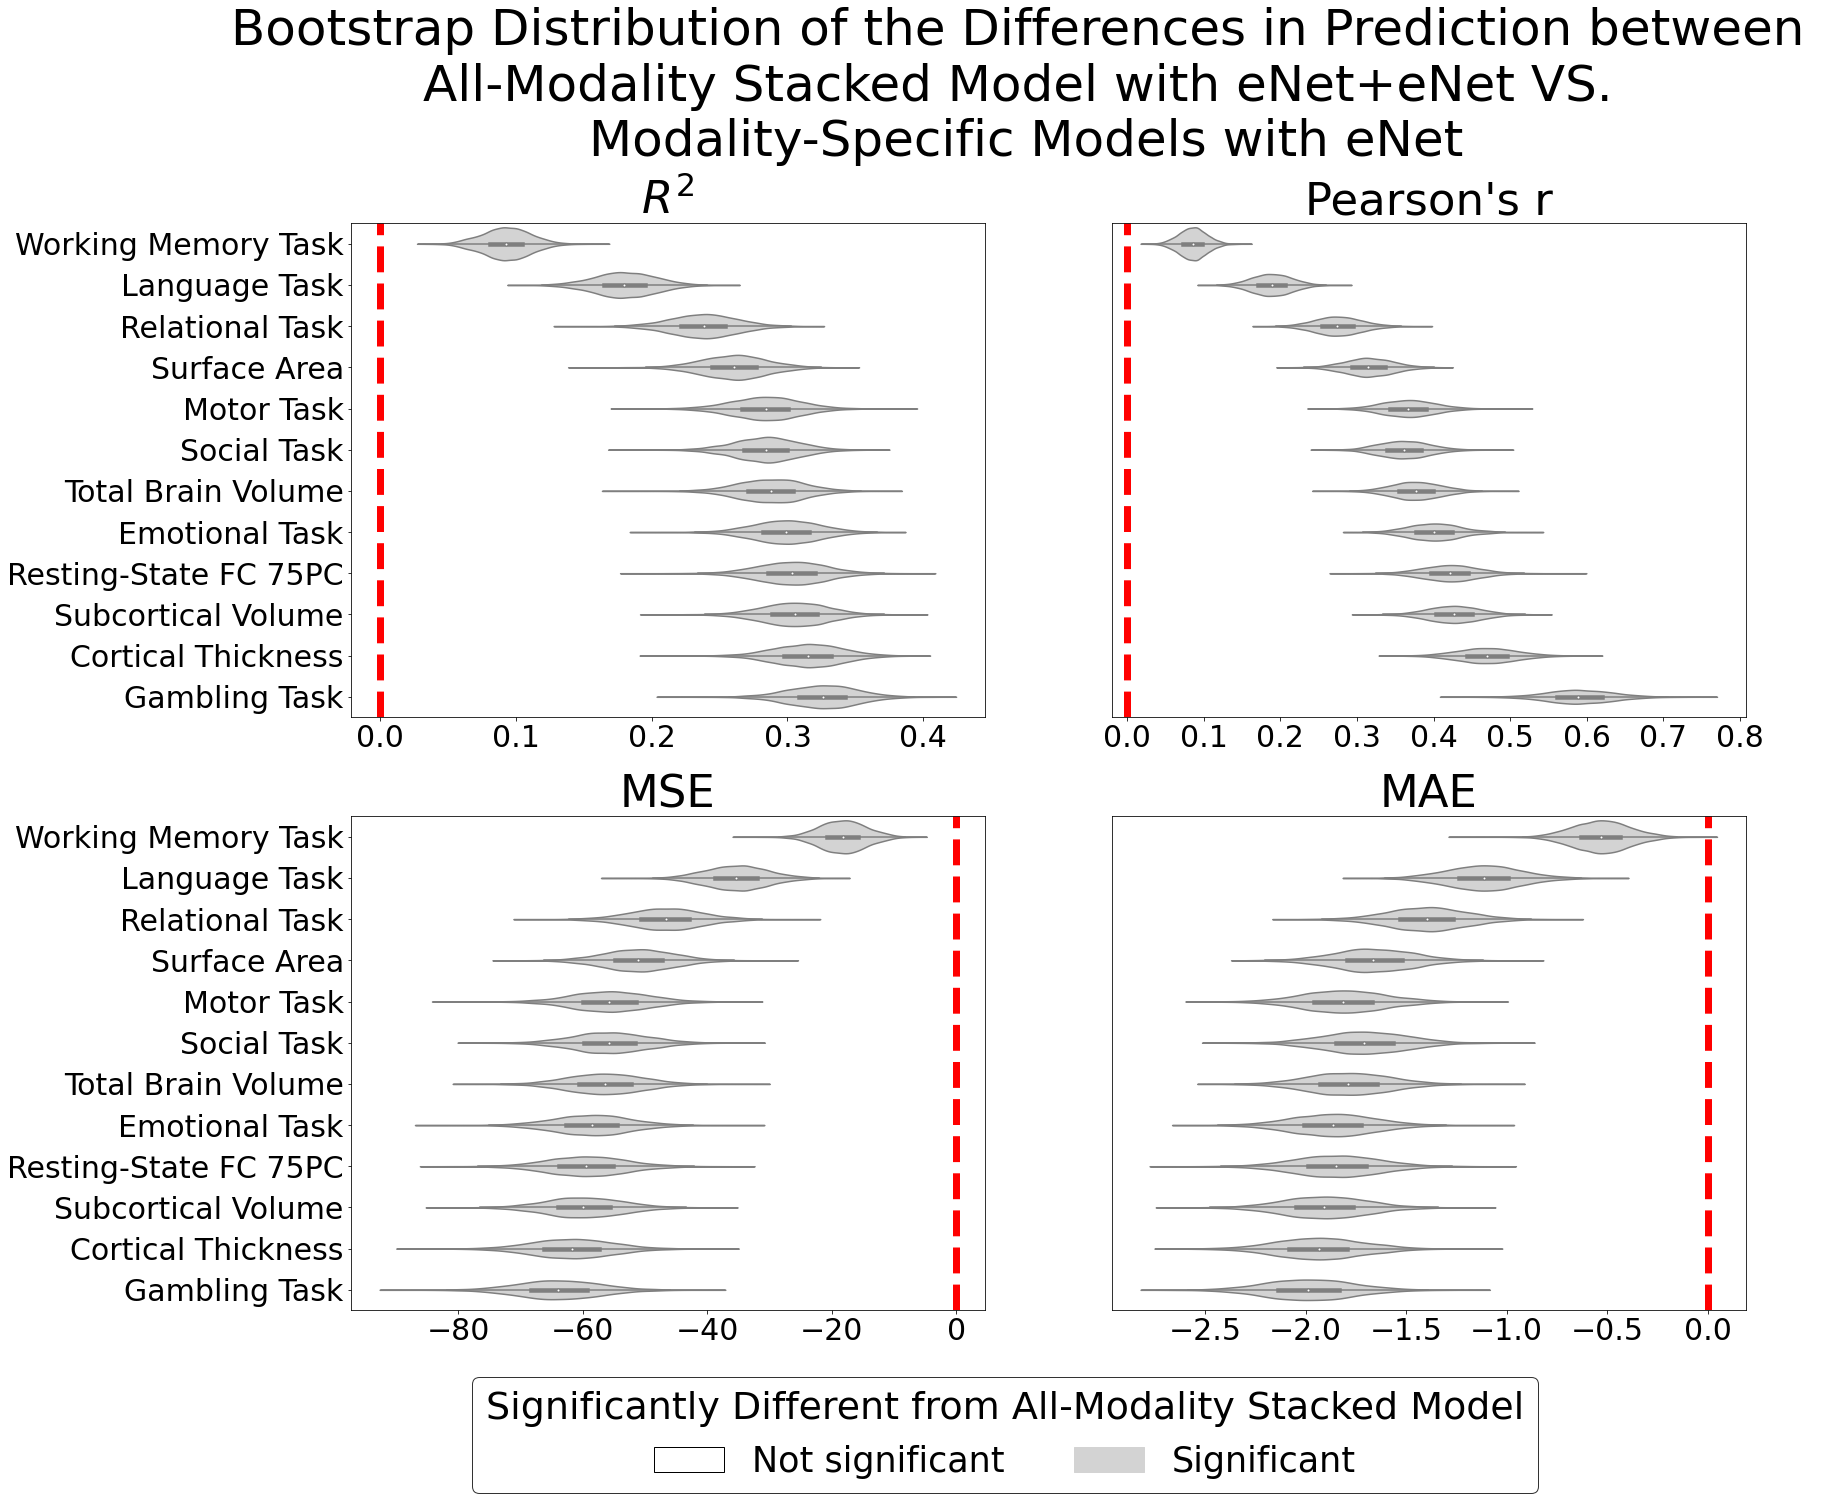

In [58]:

fig = plt.figure(figsize=(25,20))

plt.suptitle('Bootstrap Distribution of the Differences in Prediction between \nAll-Modality Stacked Model with eNet+eNet VS. \nModality-Specific Models with eNet',
         fontsize=50, y=1.03)

#dataset for r2
dataset = diff_singl.reindex(columns=[col for col in diff_singl.columns if 'flat' not in col])

CI1, CI2, colss = [],[], []
for col in dataset:
    CI1 += [(st.t.interval(alpha=0.95, df=len(dataset[col])-1, loc=np.mean(dataset[col]), scale=np.std(dataset[col])))[0]]
    CI2 += [(st.t.interval(alpha=0.95, df=len(dataset[col])-1, loc=np.mean(dataset[col]), scale=np.std(dataset[col])))[1]]
    colss += [col]
df_CI3 = pd.DataFrame({'CI1':CI1, 'CI2':CI2}, index=colss).sort_values(by='CI1', ascending=True)

dataset = dataset.reindex(columns=df_CI3.index)


#other indexes datasets
dataset_mse = diff_singl_mse.reindex(columns=df_CI3.index)
dataset_mae = diff_singl_mae.reindex(columns=df_CI3.index)
dataset_cor = diff_singl_cor.reindex(columns=df_CI3.index)

#CI for other datasets indexes (mse, mae, cor)
dct_ci_othinxs3={}
algs=['mse', 'mae', 'cor']
c=0
for dtst in [dataset_mse, dataset_mae, dataset_cor]:
    CI1, CI2, colss = [],[], []
    for col in dtst:
        CI1 += [(st.t.interval(alpha=0.95, df=len(dtst[col])-1, loc=np.mean(dtst[col]), scale=np.std(dtst[col])))[0]]
        CI2 += [(st.t.interval(alpha=0.95, df=len(dtst[col])-1, loc=np.mean(dtst[col]), scale=np.std(dtst[col])))[1]]
        colss += [col]
    dct_ci_othinxs3[algs[c]]= pd.DataFrame({'CI1':CI1, 'CI2':CI2}, index=colss).sort_values(by='CI1', ascending=True)
    c+=1


#labels for y-axis
ylabl = ['Working Memory Task',
 'Language Task',
 'Relational Task',
 'Surface Area',
 'Motor Task', 
 'Social Task',
 'Total Brain Volume',
 'Emotional Task', 
 'Resting-State FC 75PC',
 'Subcortical Volume',
 'Cortical Thickness',
 'Gambling Task']

        
###plot r2  

plt.subplot(2,2,1)

plt.title("$R^2$", fontsize=45)

#color pallete r2
my_pal = {}
for ind in df_CI3.index:
    if df_CI3.loc[ind, 'CI1'] <=0:
        my_pal[ind] = 'white'
    else:
        my_pal[ind] = 'lightgray'

sns.violinplot(data=dataset, orient='h', palette=my_pal)

plt.axvline(0, color='r', linestyle='dashed', linewidth=7)
#mod=0
#plt.axvline(df_CI3.iloc[mod,0], color='black', linestyle='dashed', linewidth=1)
#plt.axvline(df_CI3.iloc[mod,1], color='black', linestyle='dashed', linewidth=1)
plt.yticks(np.arange(len(ylabl)), ylabl, fontsize=30)
plt.xticks(fontsize=30)


###plot mse

plt.subplot(2,2,3)

plt.title("MSE", fontsize=45)

#color pallete mse
my_pal2 = {}
for ind in dct_ci_othinxs3['mse'].index:
    if dct_ci_othinxs3['mse'].loc[ind, 'CI2'] >=0:
        my_pal2[ind] = 'white'
    else:
        my_pal2[ind] = 'lightgray'

sns.violinplot(data=dataset_mse, orient='h', palette=my_pal2)

#mod=dct_ci_othinxs3['mse'].sort_values(by='CI2', ascending=False).index[0]
#plt.axvline(dct_ci_othinxs3['mse'].loc[mod,'CI1'], color='black', linestyle='dashed', linewidth=1)
#plt.axvline(dct_ci_othinxs3['mse'].loc[mod,'CI2'], color='black', linestyle='dashed', linewidth=1)

plt.axvline(0, color='r', linestyle='dashed', linewidth=7)
plt.yticks(np.arange(len(ylabl)), ylabl, fontsize=30)
plt.xticks(fontsize=30)


###plot mae

plt.subplot(2,2,4)

plt.title("MAE", fontsize=45)

#color pallete mae
my_pal3 = {}
for ind in dct_ci_othinxs3['mae'].index:
    if dct_ci_othinxs3['mae'].loc[ind, 'CI2'] >=0:
        my_pal3[ind] = 'white'
    else:
        my_pal3[ind] = 'lightgray'

sns.violinplot(data=dataset_mae, orient='h', palette=my_pal3)

#mod=dct_ci_othinxs3['mae'].sort_values(by='CI2', ascending=False).index[0]
#plt.axvline(dct_ci_othinxs3['mae'].loc[mod,'CI1'], color='black', linestyle='dashed', linewidth=1)
#plt.axvline(dct_ci_othinxs3['mae'].loc[mod,'CI2'], color='black', linestyle='dashed', linewidth=1)

plt.axvline(0, color='r', linestyle='dashed', linewidth=7)
plt.yticks([])
plt.xticks(fontsize=30)

plt.legend(handles=[mpatches.Patch(edgecolor='black', facecolor='white',  label='Not significant'), 
                    mpatches.Patch(color='lightgray', label='Significant')], 
                    fontsize=35, bbox_to_anchor=(0.7, -0.1), 
                    title="Significantly Different from All-Modality Stacked Model", 
           title_fontsize=38, ncol=2, edgecolor='black')
###plot cor

plt.subplot(2,2,2)

plt.title("Pearson's r", fontsize=45)

#color pallete mae
my_pal4 = {}
for ind in dct_ci_othinxs3['cor'].index:
    if dct_ci_othinxs3['cor'].loc[ind, 'CI1'] <=0:
        my_pal4[ind] = 'white'
    else:
        my_pal4[ind] = 'lightgray'

sns.violinplot(data=dataset_cor, orient='h', palette=my_pal4)

#mod=dct_ci_othinxs3['cor'].sort_values(by='CI1', ascending=True).index[0]
#plt.axvline(dct_ci_othinxs3['cor'].loc[mod,'CI1'], color='black', linestyle='dashed', linewidth=1)
#plt.axvline(dct_ci_othinxs3['cor'].loc[mod,'CI2'], color='black', linestyle='dashed', linewidth=1)

plt.axvline(0, color='r', linestyle='dashed', linewidth=7)
plt.yticks([])
plt.xticks(fontsize=30)





#fig.tight_layout()

plt.show()

In [43]:
df_CI3 #r2

,CI1,CI2
all_-_wm,0.058289,0.127574
all_-_lan,0.135746,0.224359
all_-_rel,0.189571,0.286337
all_-_surf,0.213058,0.307685
all_-_mot,0.234073,0.333203
all_-_soc,0.237411,0.330405
all_-_VolBrain,0.239465,0.335597
all_-_emo,0.249924,0.347620
all_-_rest-pca75,0.252520,0.353000
all_-_subc,0.256447,0.353235


In [44]:
dct_ci_othinxs3['mse']

,CI1,CI2
all_-_gam,-76.847967,-50.920461
all_-_cort,-74.429324,-49.127594
all_-_subc,-71.996705,-47.643260
all_-_rest-pca75,-71.921629,-46.909524
all_-_emo,-70.790354,-46.467766
all_-_VolBrain,-68.272026,-44.573266
all_-_mot,-67.774448,-43.551942
all_-_soc,-67.575550,-43.880571
all_-_surf,-62.231766,-39.933757
all_-_rel,-58.090243,-35.322222


In [45]:
dct_ci_othinxs3['mae']

,CI1,CI2
all_-_gam,-2.414303,-1.555742
all_-_cort,-2.356843,-1.510980
all_-_subc,-2.318105,-1.496503
all_-_emo,-2.276239,-1.454723
all_-_rest-pca75,-2.266429,-1.429113
all_-_mot,-2.221309,-1.402452
all_-_VolBrain,-2.192793,-1.386055
all_-_soc,-2.115877,-1.301642
all_-_surf,-2.056269,-1.269627
all_-_rel,-1.786658,-1.011686


In [46]:
dct_ci_othinxs3['cor']

,CI1,CI2
all_-_wm,0.050045,0.120604
all_-_lan,0.137707,0.239360
all_-_rel,0.214448,0.335473
all_-_surf,0.253184,0.377390
all_-_soc,0.296621,0.425898
all_-_mot,0.298573,0.435269
all_-_VolBrain,0.312854,0.440833
all_-_emo,0.333548,0.467730
all_-_rest-pca75,0.349210,0.492440
all_-_subc,0.358409,0.493662


# Bootstrapped difference between "eNet-eNet" All-TASK stacked model and others models/algorithms

In [47]:

#calculate difference between All-Task stacked model (set1) and others
#empty dict for storing results
dct_diff_stack_T = {}
dct_diff_stack_mse_T = {}
dct_diff_stack_mae_T = {}
dct_diff_stack_cor_T = {}

#for stacking models in 'eNet+eNet'
for col in dct_bootstrap_r2['eNet+eNet'].reindex(columns=['all', 'non-task', 'top-task']).columns:
    dct_diff_stack_T['task' + '_-_' + col] = dct_bootstrap_r2['eNet+eNet']['task'] - dct_bootstrap_r2['eNet+eNet'][col]
    
#for stacking models in 'eNet+eNet'
for col in dct_bootstrap_mse['eNet+eNet'].reindex(columns=['all', 'non-task', 'top-task']).columns:
    dct_diff_stack_mse_T['task' + '_-_' + col] = dct_bootstrap_mse['eNet+eNet']['task'] - dct_bootstrap_mse['eNet+eNet'][col]

#for stacking models in 'eNet+eNet'
for col in dct_bootstrap_mae['eNet+eNet'].reindex(columns=['all', 'non-task', 'top-task']).columns:
    dct_diff_stack_mae_T['task' + '_-_' + col] = dct_bootstrap_mae['eNet+eNet']['task'] - dct_bootstrap_mae['eNet+eNet'][col]

#for stacking models in 'eNet+eNet'
for col in dct_bootstrap_cor['eNet+eNet'].reindex(columns=['all', 'non-task', 'top-task']).columns:
    dct_diff_stack_cor_T['task' + '_-_' + col] = dct_bootstrap_cor['eNet+eNet']['task'] - dct_bootstrap_cor['eNet+eNet'][col]


#transform dict to tables
diff_stack_T = pd.DataFrame(dct_diff_stack_T)    
diff_stack_mse_T = pd.DataFrame(dct_diff_stack_mse_T)
diff_stack_mae_T = pd.DataFrame(dct_diff_stack_mae_T)
diff_stack_cor_T = pd.DataFrame(dct_diff_stack_cor_T)


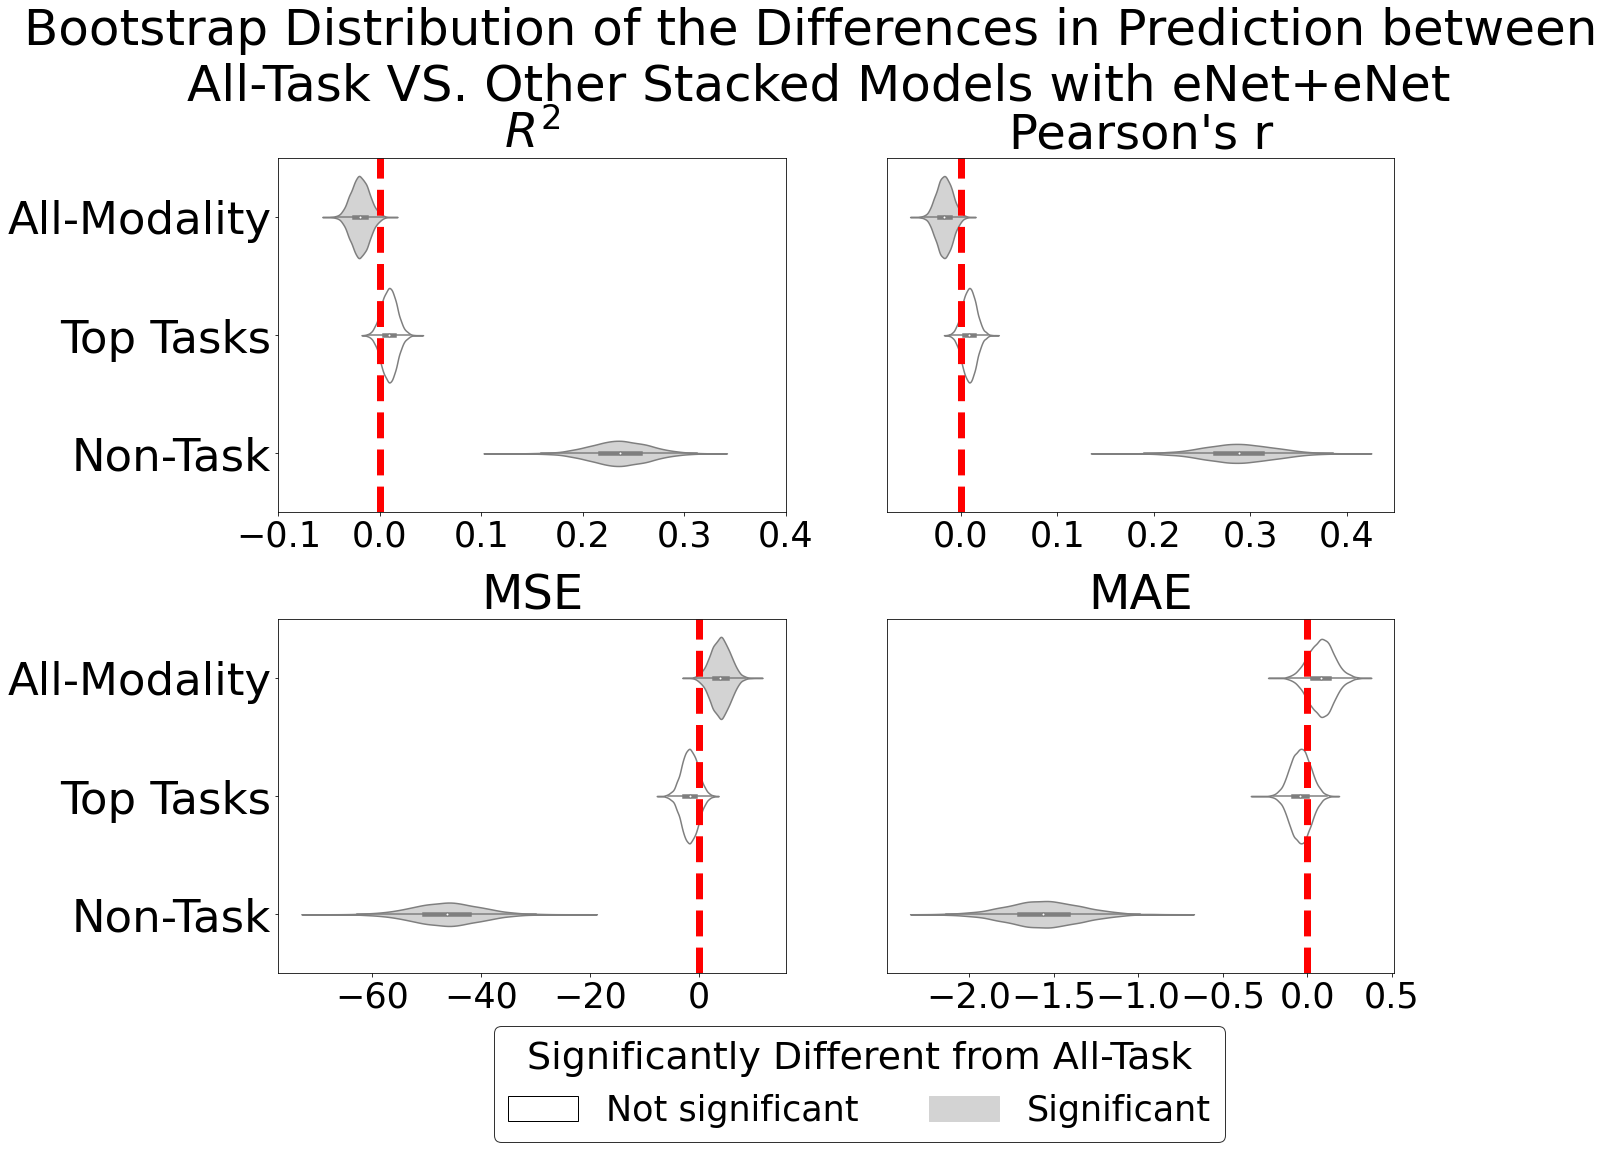

In [57]:
fig = plt.figure(figsize=(20,15))

plt.suptitle('Bootstrap Distribution of the Differences in Prediction between \nAll-Task VS. Other Stacked Models with eNet+eNet',
         fontsize=50, y=1.02)#

#dataset for r2
dataset = diff_stack_T.reindex(columns=[col for col in diff_stack_T.columns if 'flat' not in col])

CI1, CI2, colss = [],[], []
for col in dataset:
    CI1 += [(st.t.interval(alpha=0.95, df=len(dataset[col])-1, loc=np.mean(dataset[col]), scale=np.std(dataset[col])))[0]]
    CI2 += [(st.t.interval(alpha=0.95, df=len(dataset[col])-1, loc=np.mean(dataset[col]), scale=np.std(dataset[col])))[1]]
    colss += [col]
df_CI2 = pd.DataFrame({'CI1':CI1, 'CI2':CI2}, index=colss).sort_values(by='CI1', ascending=True)

dataset = dataset.reindex(columns=df_CI2.index)


#other indexes datasets
dataset_mse = diff_stack_mse_T.reindex(columns=df_CI2.index)
dataset_mae = diff_stack_mae_T.reindex(columns=df_CI2.index)
dataset_cor = diff_stack_cor_T.reindex(columns=df_CI2.index)

#CI for other datasets indexes (mse, mae, cor)
dct_ci_othinxs2={}
algs=['mse', 'mae', 'cor']
c=0
for dtst in [dataset_mse, dataset_mae, dataset_cor]:
    CI1, CI2, colss = [],[], []
    for col in dtst:
        CI1 += [(st.t.interval(alpha=0.95, df=len(dtst[col])-1, loc=np.mean(dtst[col]), scale=np.std(dtst[col])))[0]]
        CI2 += [(st.t.interval(alpha=0.95, df=len(dtst[col])-1, loc=np.mean(dtst[col]), scale=np.std(dtst[col])))[1]]
        colss += [col]
    dct_ci_othinxs2[algs[c]]= pd.DataFrame({'CI1':CI1, 'CI2':CI2}, index=colss).sort_values(by='CI1', ascending=True)
    c+=1


#labels for y-axis
ylabl = ['All-Modality',
        'Top Tasks',
        'Non-Task']

        
###plot r2  

plt.subplot(2,2,1)

plt.title("$R^2$", fontsize=48)

#color pallete r2
my_pal = {}
for ind in df_CI2.index:
    if df_CI2.loc[ind, 'CI1'] <0 and df_CI2.loc[ind, 'CI2']<0:
        my_pal[ind] = 'lightgray'
    if df_CI2.loc[ind, 'CI1'] <0 and df_CI2.loc[ind, 'CI2']>0:
        my_pal[ind] = 'white'
    else:
        my_pal[ind] = 'lightgray'

sns.violinplot(data=dataset, orient='h', palette=my_pal)

plt.axvline(0, color='r', linestyle='dashed', linewidth=7)
#mod=2
#plt.axvline(df_CI2.iloc[mod,0], color='black', linestyle='dashed', linewidth=1)
#plt.axvline(df_CI2.iloc[mod,1], color='black', linestyle='dashed', linewidth=1)
plt.yticks(np.arange(len(ylabl)), ylabl, fontsize=45)
plt.xticks([-0.1,0,0.1,0.2,0.3,0.4], fontsize=35)


###plot mse

plt.subplot(2,2,3)

plt.title("MSE", fontsize=48)

#color pallete mse
my_pal2 = {}
for ind in dct_ci_othinxs2['mse'].index:
    if dct_ci_othinxs2['mse'].loc[ind, 'CI1'] >0 and dct_ci_othinxs2['mse'].loc[ind, 'CI2']>0:
        my_pal2[ind] = 'lightgray'
    if dct_ci_othinxs2['mse'].loc[ind, 'CI1'] <0 and dct_ci_othinxs2['mse'].loc[ind, 'CI2']>0:
        my_pal2[ind] = 'white'

    else:
        my_pal2[ind] = 'lightgray'

sns.violinplot(data=dataset_mse, orient='h', palette=my_pal2)

#mod=dct_ci_othinxs2['mse'].sort_values(by='CI2', ascending=False).index[2]
#plt.axvline(dct_ci_othinxs2['mse'].loc[mod,'CI1'], color='black', linestyle='dashed', linewidth=1)
#plt.axvline(dct_ci_othinxs2['mse'].loc[mod,'CI2'], color='black', linestyle='dashed', linewidth=1)

plt.axvline(0, color='r', linestyle='dashed', linewidth=7)
plt.yticks(np.arange(len(ylabl)), ylabl, fontsize=45)
plt.xticks(fontsize=35)


###plot mae

plt.subplot(2,2,4)

plt.title("MAE", fontsize=48)

#color pallete mae
my_pal3 = {}
for ind in dct_ci_othinxs2['mae'].index:        
    if dct_ci_othinxs2['mae'].loc[ind, 'CI1'] >0 and dct_ci_othinxs2['mae'].loc[ind, 'CI2'] >0:
        my_pal3[ind] = 'lightgray'
    if dct_ci_othinxs2['mae'].loc[ind, 'CI1'] <0 and dct_ci_othinxs2['mae'].loc[ind, 'CI2'] >0:
        my_pal3[ind] = 'white'

    else:
        my_pal3[ind] = 'lightgray'

sns.violinplot(data=dataset_mae, orient='h', palette=my_pal3)

#mod=dct_ci_othinxs2['mae'].sort_values(by='CI2', ascending=False).index[2]
#plt.axvline(dct_ci_othinxs2['mae'].loc[mod,'CI1'], color='black', linestyle='dashed', linewidth=1)
#plt.axvline(dct_ci_othinxs2['mae'].loc[mod,'CI2'], color='black', linestyle='dashed', linewidth=1)

plt.axvline(0, color='r', linestyle='dashed', linewidth=7)
plt.yticks([])
plt.xticks(fontsize=35)

plt.legend(handles=[mpatches.Patch(edgecolor='black', facecolor='white',  label='Not significant'), 
                    mpatches.Patch(color='lightgray', label='Significant')], 
                    fontsize=35, bbox_to_anchor=(0.7, -0.1), 
                    title="Significantly Different from All-Task", 
           title_fontsize=38, ncol=2, edgecolor='black')

###plot cor

plt.subplot(2,2,2)

plt.title("Pearson's r", fontsize=48)

#color pallete mae


my_pal4 = {}
for ind in dct_ci_othinxs2['cor'].index:
    if dct_ci_othinxs2['cor'].loc[ind, 'CI1'] <0 and dct_ci_othinxs2['cor'].loc[ind, 'CI2']<0:
        my_pal4[ind] = 'lightgray'
    if dct_ci_othinxs2['cor'].loc[ind, 'CI1'] <0 and dct_ci_othinxs2['cor'].loc[ind, 'CI2']>0:
        my_pal4[ind] = 'white'
    else:
        my_pal4[ind] = 'lightgray'

sns.violinplot(data=dataset_cor, orient='h', palette=my_pal4)

#mod=dct_ci_othinxs2['cor'].sort_values(by='CI1', ascending=True).index[2]
#plt.axvline(dct_ci_othinxs2['cor'].loc[mod,'CI1'], color='black', linestyle='dashed', linewidth=1)
#plt.axvline(dct_ci_othinxs2['cor'].loc[mod,'CI2'], color='black', linestyle='dashed', linewidth=1)

plt.axvline(0, color='r', linestyle='dashed', linewidth=7)
plt.yticks([])
plt.xticks(fontsize=35)





#fig.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.show()

In [49]:
df_CI2 #r2

,CI1,CI2
task_-_all,-0.036775,-0.002405
task_-_top-task,-0.005677,0.023888
task_-_non-task,0.179375,0.293049


In [50]:
dct_ci_othinxs2['mse']

,CI1,CI2
task_-_non-task,-58.451066,-34.189179
task_-_top-task,-4.685495,1.113637
task_-_all,0.427979,7.274101


In [51]:
dct_ci_othinxs2['mae']

,CI1,CI2
task_-_non-task,-1.990100,-1.131214
task_-_top-task,-0.157931,0.075002
task_-_all,-0.062779,0.226635


In [52]:
dct_ci_othinxs2['cor']

,CI1,CI2
task_-_all,-0.033328,-0.001331
task_-_top-task,-0.005485,0.022442
task_-_non-task,0.216849,0.359203
